### This file analyses clusters of data to understand how it is affected by external criteria (mass, power and type of work)

In [1]:
%%capture
import pandas as pd
# import modin.pandas as pd
import numpy as np

import math
import seaborn as sns
import matplotlib.pyplot as plt
# import vaex # https://vaex.io/docs/index.html
import pathlib
from pathlib import *
import os
import pickle
# import cufflinks as cf
# import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot

init_notebook_mode(connected=True)
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from shapely.geometry import Point, Polygon

In [2]:
##TODO -> Create functions for repetitive tasks

# ,skiprows=range(3, 260000000)
# Input the csv
# Extracting a subset of 1000000 rows by default
def load_data(dir_name,base_filename):
    complete_path=os.path.join(dir_name, base_filename + "." + "csv")
    # df=pd.read_csv(complete_path,sep=';',encoding= 'unicode_escape',nrows=10000,engine='c',infer_datetime_format=True,usecols=['Trip_Summary_Id','Numberplate','Point_time-stamp','Latitude',
    #                                                                                                                           'Longitude','Meters_travelled','Time_elapsed','Point_speed','Number_of_lanes',
    #                                                                                                                           'Road_type','Road_class','Road_form','Speed_restriction','TNO_Time-stamp'])
    # df = pd.concat((chunk for chunk in pd.read_csv(complete_path,sep=';',nrows=5000000,encoding= 'unicode_escape',engine='c',infer_datetime_format=True,chunksize=1000000,low_memory=False,usecols=['Numberplate','Latitude',
    #                                                                                                                           'Longitude','Meters_travelled','Time_elapsed','Point_speed','Number_of_lanes',
    #                                                                                                                           'Road_type','Road_class','Speed_restriction','TNO_Time-stamp'])))
    
    df = pd.concat((chunk for chunk in pd.read_csv(complete_path,sep=';',nrows=20000000,encoding= 'unicode_escape',engine='c',infer_datetime_format=True,chunksize=1000000,low_memory=False)))
    return df

# Dropping the first and last row of csv ("------")
def drop_first_row(df):
    df=df.iloc[1:]
    df=df[:-1]
    return df

def resetIndex(df):
    return df.reset_index()


##TODO -> Rewrite this function

def cast_to_correct_dtype(df):
    
    if 'Id' in df.columns:
        df['Id'] = df['Id'].astype('int')
        
    if 'AOS_position_Id' in df.columns:
        df['AOS_position_Id'] = df['AOS_position_Id'].astype('int')
    
    if 'Acceleration_x' in df.columns:
        df['Acceleration_x'] = df['Acceleration_x'].astype('float')
        
    if 'Acceleration_y' in df.columns:
        df['Acceleration_y'] = df['Acceleration_y'].astype('float')
        
    if 'TNO_Valid' in df.columns:
        df['TNO_Valid'] = df['TNO_Valid'].astype('int')
    
    if 'Latitude' in df.columns:
        df['Latitude'] = df['Latitude'].astype('float')
        
    if 'Longitude' in df.columns:
        df['Longitude'] = df['Longitude'].astype('float')
        
    if 'Event/action_speed' in df.columns:
        df['Event/action_speed'] = df['Event/action_speed'].astype('int')
        
    if 'Event/action_type' in df.columns:
        df['Event/action_type'] = df['Event/action_type'].astype('int')    
        
    if 'Number_of_lanes' in df.columns:
        df['Number_of_lanes'] = df['Number_of_lanes'].astype('int')
        
    if 'Road_class' in df.columns:
        df['Road_class'] = df['Road_class'].astype('int')
        
    if 'Road_type' in df.columns:
        df['Road_type'] = df['Road_type'].astype('int')
        
    if 'Crash_position_Id' in df.columns:
        df['Crash_position_Id']=df['Crash_position_Id'].astype('int')
        
    if 'Crash_position_Id' in df.columns:
        df['Crash_position_Id'] = df['Crash_position_Id'].astype('int')
        
    if 'Point_speed' in df.columns:
        df['Point_speed'] = df['Point_speed'].astype('float')
        
    if 'Average_speed_fpp' in df.columns:
        df['Average_speed_fpp'] = df['Average_speed_fpp'].astype('float')  
        
    if 'Average_Speed' in df.columns:
        df['Average_Speed'] = df['Average_Speed'].astype('float')        

    if 'Maximum_speed' in df.columns:
        df['Maximum_speed'] = df['Maximum_speed'].astype('float')     
        
    if 'Meters_travelled' in df.columns:
        df['Meters_travelled'] = df['Meters_travelled'].astype('int')  

    if 'Road_form' in df.columns:
        df['Road_form'] = df['Road_form'].astype('int') 
        
    if 'Speed_restriction' in df.columns:
        df['Speed_restriction'] = df['Speed_restriction'].astype('int') 
        
    if 'Crash_speed' in df.columns:
        df['Crash_speed'] = df['Crash_speed'].astype('int')
        
    if 'Maximum_acceleration' in df.columns:
        df['Maximum_acceleration'] = df['Maximum_acceleration'].astype('float')
        
    if 'Numberplate' in df.columns:
        df['Numberplate']=df['Numberplate'].astype('str')
        

    return df

            

## Handling date time related fields

def cast_date_time(df):
    if 'AOS_event/action_time' in df.columns:
        df['AOS_event/action_time']=pd.datetime(df['AOS_event/action_time'],errors='coerce')
        df['AOS_event/action_time_hour']=df['AOS_event/action_time'].dt.hour
    
    if 'TNO_Trip-start' in df.columns:
        df['TNO_Trip-start'] = pd.to_datetime(df['TNO_Trip-start'],errors='coerce')
        df['TNO_Trip-start_hour'] = df['TNO_Trip-start'].dt.hour
        
    if 'TNO_Trip-end' in df.columns:
        df['TNO_Trip-end'] = pd.to_datetime(df['TNO_Trip-end'],errors='coerce')
        
    if 'Position_time' in df.columns:
        df['Position_time'] = pd.to_datetime(df['Position_time'],errors='coerce')

    if 'TNO_Time-stamp' in df.columns:
        df['TNO_Time-stamp'] = pd.to_datetime(df['TNO_Time-stamp'],errors='coerce')
        df['TNO_Time-stamp_hour'] = df['TNO_Time-stamp'].dt.hour
        
    return df

## Converting Time Stamps to datetime

def date_and_time_columns(df):
    if 'AOS_event/action_time' in df.columns:
        df['AOS Trip Date']=df['AOS_event/action_time'].dt.date
        df['AOS Event Time']=df['AOS_event/action_time'].dt.time
        df['AOS Trip Hour']=df['AOS_event/action_time'].dt.hour
    
    
    if 'TNO_Time-stamp' in df.columns:
        df['TNO Trip Date'] = df['TNO_Time-stamp'].dt.date
        df['TNO Trip Time'] = df['TNO_Time-stamp'].dt.time
        df['TNO Trip Hour']=df['TNO_Time-stamp'].dt.hour
        # df['TNO Trip Hour'] = df['TNO Trip Time'].dt.hour
    return df

def Time_of_the_day(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x < 12 ):
        return 'Morning'
    elif (x >= 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'
    
    
def rename_some_stuff(df):
    if 'Event/action_type' in df.columns:
        df["Event type Rename"]=df["Event/action_type"].replace({0: 'Headway Warning = OFF', 1: 'Headway Warning (long)', 2: 'Headway Warning (medium)'
                                                                                 ,3: 'Headway Warning (short)',10:'Lane Departure Warning = OFF',11:'Left Lane Departure Warning = ON'
                                                                                 ,12:'Right Lane Departure Warning = ON',13:'Left and Right Lane Departure Warning = ON'
                                                                                 ,20:' Indicators = OFF',21:'Left Indicator = ON',22:'Right Indicator = ON',23:'Left and Right Indicator = ON'
                                                                                 ,40:'Brakes = OFF',41:'Brakes = ON'})
        
    if 'Road_type' in df.columns:
        df["Road_type_Rename"]=df["Road_type"].replace({0: "Urban", 1: "Motorway",2:"Extra Urban",3:"Unavailable"})
        
    return df

def detect_overspeeding_count(df):
    # create a list of our conditions
    # if 'Event/action_speed' and 'Speed_restriction' in df.columns:
    #     conditions = [(df['Event/action_speed']> df['Speed_restriction'])]
    #     # # create a list of the values we want to assign for each condition
    #     values = [1]
    #     # create a new column and use np.select to assign values to it using our lists as arguments
    #     df['Overspeeding_event'] = np.select(conditions, values)
        
    # return df

    if 'Point_speed' and 'Speed_restriction' in df.columns:
        conditions = [(df['Point_speed']> df['Speed_restriction'])]
        # # create a list of the values we want to assign for each condition
        values = [1]
        # create a new column and use np.select to assign values to it using our lists as arguments
        df['Overspeeding_event'] = np.select(conditions, values)
        
    return df

def some_processing(df):
    if 'Meters_travelled' in df.columns:
        df['KmTravelled']=df['Meters_travelled']/1000
    return df

In [3]:
def select_city_to_explore(city_name):
    if city_name=='Amsterdam':
        city_coordinates = [(52.430779, 4.737382), (52.422361, 4.811680), (52.418126, 4.850948), 
                            (52.431506, 4.859627),(52.421959, 4.913905),(52.414543, 4.933522),(52.425437, 4.954927),
                            (52.428570, 4.982090),(52.423581, 5.017310),(52.417493, 5.067539),(52.397841, 5.031621),
                            (52.373215, 5.014760),(52.352051, 5.030236),(52.324595, 5.019149),(52.304151, 5.024817),
                            (52.277836, 4.960200),(52.307825, 4.925153),(52.318055, 4.910773),(52.323740, 4.820309),
                            (52.339239, 4.789761),(52.357192, 4.752847),(52.387835, 4.753389),(52.399444, 4.729131),(52.430091, 4.737165)]
    elif city_name=='Rotterdam':
        city_coordinates = [(51.964720, 4.379695), (51.979081, 4.427803), (51.982006, 4.467663), 
                            (51.963745, 4.515691),(51.975121, 4.546658),(51.986527, 4.558397),(51.995767, 4.594196),
                            (51.968611, 4.599813),(51.955476, 4.566894),(51.943379, 4.576685),(52.397841, 5.031621),
                            (51.905291, 4.577125),(51.868921, 4.570220),(51.868888, 4.396928),(51.964029, 4.377486)]
        
    elif city_name =="Zwolle":
        city_coordinates = [(52.549349, 6.004091), (52.568947, 6.063982), (52.554697, 6.089382), (52.568898, 6.101135),
                         (52.555875, 6.138225),(52.566288, 6.160296),(52.585973, 6.144575),(52.569103, 6.212615),
                         (52.537363, 6.193830),(52.517736, 6.181333),(52.495107, 6.202496),(52.480071, 6.194845),
                         (52.467620, 6.150828),(52.447958, 6.155530),(52.440524, 6.103350),(52.508357, 6.024621),
                         (52.526347, 6.010919),(52.531352, 6.026051),(52.550606, 5.999967)]
        
    return city_name,city_coordinates


In [4]:
city_name,city_coords=select_city_to_explore('Amsterdam')
# city_name,city_coords=select_city_to_explore('Rotterdam')
# city_name,city_coords=select_city_to_explore('Zwolle')

In [5]:
def load_files(city_name):
    # city_name,_=select_city_to_explore('Amsterdam')
    if city_name == 'Amsterdam':
        df_intra_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Amsterdam\df_grp_aos_trip_detail_amsterdam.csv")
        df_inter_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Amsterdam\df_grp_aos_trip_detail_complete_amsterdam_updated2.csv")
        city_name='Amsterdam'
        location="Amsterdam"
        location1="across cities the NL"
        
    elif city_name=='Rotterdam':
        df_intra_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Rotterdam\df_grp_aos_trip_detail_rotterdam.csv")
        df_inter_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Rotterdam\df_grp_aos_trip_detail_complete_rotterdam_updated2.csv")
        city_name='Rotterdam'
        location="Rotterdam"
        location1="across cities the NL"
        
    elif city_name=='Zwolle':
        df_intra_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Zwolle\df_grp_aos_trip_detail_zwolle.csv")
        df_inter_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Zwolle\df_grp_aos_trip_detail_complete_zwolle_updated2.csv")
        city_name='Zwolle'
        location="Zwolle"
        location1="across cities the NL"
        
    return df_intra_city,df_inter_city,city_name,location,location1


In [6]:
df_intra_city,df_inter_city,city_name,location,location1=load_files(city_name) # This function should run automatically if you've called `select_city_to_explore` function before

In [7]:
df_intra_city

,Unnamed: 0,Numberplate,Point_speed,Km_travelled,Indicators = OFF,Brakes = OFF,Brakes = ON,Headway Warning (long),Headway Warning (medium),Headway Warning (short),...,norm_headway_warning(medium),norm_headway_warning(short),norm_Headway Warning = OFF,norm_Lane Departure Warning = OFF,norm_Left Indicator = ON,norm_Left Lane Departure Warning = ON,norm_Left and Right Indicator = ON,norm_Right Indicator = ON,norm_Right Lane Departure Warning = ON,City
0,0,BBRX80,57.165049,223.600,0,0,0,300,31,70,...,0.138640,0.313059,1.135957,0.084973,0.000000,0.031306,0.000000,0.000000,0.049195,Amsterdam
1,1,BBSN73,63.705882,163.984,0,0,0,47,50,53,...,0.304908,0.323202,0.207337,0.018294,0.000000,0.006098,0.000000,0.000000,0.012196,Amsterdam
2,2,BBXH49,68.750000,64.727,144,30,28,50,7,8,...,0.108147,0.123596,0.726127,0.077248,0.911521,0.015450,1.050566,0.278091,0.061798,Amsterdam
3,5,BFHD67,59.322581,246.842,0,0,0,245,45,12,...,0.182303,0.048614,0.996589,0.230917,0.000000,0.016205,0.000000,0.000000,0.214712,Amsterdam
4,6,BFRT22,42.835165,163.644,0,0,0,176,29,42,...,0.177214,0.256655,0.959400,0.317763,0.000000,0.012222,0.000000,0.000000,0.305541,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,897,NNB302,72.776860,264.858,0,0,0,36,12,4,...,0.045307,0.015102,0.139697,0.052859,0.000000,0.003776,0.000000,0.000000,0.052859,Amsterdam
759,898,NNB320,43.442623,111.351,0,0,0,40,11,17,...,0.098787,0.152670,0.341263,0.053884,0.000000,0.008981,0.000000,0.000000,0.035922,Amsterdam
760,899,NNB35,74.659091,222.154,0,0,0,369,57,10,...,0.256579,0.045014,1.588988,0.193559,0.000000,0.022507,0.000000,0.000000,0.162050,Amsterdam
761,900,NNB404,49.850000,162.062,0,0,0,16,4,3,...,0.024682,0.018511,0.055534,0.030852,0.000000,0.000000,0.000000,0.000000,0.024682,Amsterdam


In [8]:
class pre_processing:
    
    def __init__(self,df_intra_city,df_inter_city):
        self.df_intra_city = df_intra_city
        self.df_inter_city = df_inter_city
        
    def rename_columns(self):
        # self.df_inter_city.drop(['Unnamed: 0'], axis = 1, inplace = True) 
        # self.df_intra_city.drop(['Unnamed: 0'], axis = 1, inplace = True) 
    
        # self.df_intra_city.rename(columns={'Point_speed_mean_intra_city': 'Point_speed','KmTravelled_sum_intra_city': 'Km_travelled'},inplace=True, errors='raise')
    
        return df_intra_city,df_inter_city
    
    def concat_df(self):
        self.df_intra_city,self.df_inter_city=self.rename_columns()
        df_grouped_cities=pd.concat([self.df_intra_city, self.df_inter_city])
        return df_grouped_cities
    
    def filtering_df(self):
        df_grouped_cities=self.concat_df()
        df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['norm_brakes = ON']>4].index)
        df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['norm_headway_warning(long)']>3].index)
        df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['Point_speed']<20].index)
        df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['Km_travelled']<50].index)
        
        return df_grouped_cities
    
    
pre_processed_data = pre_processing(df_intra_city,df_inter_city)
df_grouped_cities=pre_processed_data.filtering_df() 
df_grouped_cities

,Unnamed: 0,Numberplate,Point_speed,Km_travelled,Indicators = OFF,Brakes = OFF,Brakes = ON,Headway Warning (long),Headway Warning (medium),Headway Warning (short),...,norm_headway_warning(medium),norm_headway_warning(short),norm_Headway Warning = OFF,norm_Lane Departure Warning = OFF,norm_Left Indicator = ON,norm_Left Lane Departure Warning = ON,norm_Left and Right Indicator = ON,norm_Right Indicator = ON,norm_Right Lane Departure Warning = ON,City
0,0,BBRX80,57.165049,223.600,0,0,0,300,31,70,...,0.138640,0.313059,1.135957,0.084973,0.000000,0.031306,0.000000,0.000000,0.049195,Amsterdam
1,1,BBSN73,63.705882,163.984,0,0,0,47,50,53,...,0.304908,0.323202,0.207337,0.018294,0.000000,0.006098,0.000000,0.000000,0.012196,Amsterdam
2,2,BBXH49,68.750000,64.727,144,30,28,50,7,8,...,0.108147,0.123596,0.726127,0.077248,0.911521,0.015450,1.050566,0.278091,0.061798,Amsterdam
3,5,BFHD67,59.322581,246.842,0,0,0,245,45,12,...,0.182303,0.048614,0.996589,0.230917,0.000000,0.016205,0.000000,0.000000,0.214712,Amsterdam
4,6,BFRT22,42.835165,163.644,0,0,0,176,29,42,...,0.177214,0.256655,0.959400,0.317763,0.000000,0.012222,0.000000,0.000000,0.305541,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,756,NNB302,72.667506,23552.713,0,0,0,3466,779,281,...,0.033075,0.011931,0.142744,0.092176,0.000000,0.009595,0.000000,0.000000,0.081519,Amsterdam_complete
757,757,NNB320,62.992343,11559.807,0,0,0,2569,612,522,...,0.052942,0.045156,0.206664,0.087199,0.000000,0.013582,0.000000,0.000000,0.069032,Amsterdam_complete
758,758,NNB35,67.087392,9371.739,0,0,0,6344,842,1194,...,0.089845,0.127404,0.670420,0.123136,0.000000,0.013445,0.000000,0.000000,0.099875,Amsterdam_complete
759,759,NNB404,68.499091,5721.970,0,0,0,818,241,119,...,0.042118,0.020797,0.130200,0.068683,0.000000,0.008389,0.000000,0.000000,0.056449,Amsterdam_complete


In [9]:
def select_feature_to_examine(feature):
    if feature=="norm_headway_warning(long)":
        feature_name="Norm HW-L(I) "
    
    elif feature=='norm_headway_warning(medium)':
        feature_name="Norm HW-L(II) "

    elif feature=='norm_headway_warning(short)':
        feature_name="Norm HW-L(III) "
        
    elif feature=='Point_speed':
        feature_name="Mean Point Speed "
        
    elif feature=='norm_Left Lane Departure Warning = ON':
        feature_name="Norm L-LDW "
        
    elif feature=='norm_Right Lane Departure Warning = ON':
        feature_name="Norm R-LDW "
        
    elif feature=='norm_brakes = ON':
        feature_name="Norm Braking Events "
        
    return feature,feature_name

"""Uncomment feature to be examined"""

feature,feature_name=select_feature_to_examine('Point_speed')
# feature,feature_name=select_feature_to_examine('norm_brakes = ON')
# feature,feature_name=select_feature_to_examine('norm_headway_warning(long)')
# feature,feature_name=select_feature_to_examine('norm_headway_warning(medium)')
# feature,feature_name=select_feature_to_examine('norm_headway_warning(short)')
# feature,feature_name=select_feature_to_examine('norm_Left Lane Departure Warning = ON')
# feature,feature_name=select_feature_to_examine('norm_Right Lane Departure Warning = ON')

In [10]:
df_outer = pd.merge(df_intra_city, df_inter_city, on='Numberplate', how='inner') #here Numberplate is common column
df_outer

,Unnamed: 0_x,Numberplate,Point_speed_x,Km_travelled_x,Indicators = OFF_x,Brakes = OFF_x,Brakes = ON_x,Headway Warning (long)_x,Headway Warning (medium)_x,Headway Warning (short)_x,...,norm_headway_warning(medium)_y,norm_headway_warning(short)_y,norm_Headway Warning = OFF_y,norm_Lane Departure Warning = OFF_y,norm_Left Indicator = ON_y,norm_Left Lane Departure Warning = ON_y,norm_Left and Right Indicator = ON_y,norm_Right Indicator = ON_y,norm_Right Lane Departure Warning = ON_y,City_y
0,0,BBRX80,57.165049,223.600,0,0,0,300,31,70,...,0.094140,0.171379,0.799119,0.116441,0.000000,0.027423,0.000000,0.000000,0.086225,Amsterdam_complete
1,1,BBSN73,63.705882,163.984,0,0,0,47,50,53,...,0.203465,0.303001,0.336110,0.013429,0.000000,0.003801,0.000000,0.000000,0.003801,Amsterdam_complete
2,2,BBXH49,68.750000,64.727,144,30,28,50,7,8,...,0.116013,0.165977,0.714636,0.061100,0.584954,0.026750,0.364948,0.857693,0.030108,Amsterdam_complete
3,5,BFHD67,59.322581,246.842,0,0,0,245,45,12,...,0.103540,0.146351,0.615161,0.170541,0.000000,0.041871,0.000000,0.000000,0.125455,Amsterdam_complete
4,6,BFRT22,42.835165,163.644,0,0,0,176,29,42,...,0.148517,0.220342,0.701513,0.315623,0.000000,0.022774,0.000000,0.000000,0.289442,Amsterdam_complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,897,NNB302,72.776860,264.858,0,0,0,36,12,4,...,0.033075,0.011931,0.142744,0.092176,0.000000,0.009595,0.000000,0.000000,0.081519,Amsterdam_complete
757,898,NNB320,43.442623,111.351,0,0,0,40,11,17,...,0.052942,0.045156,0.206664,0.087199,0.000000,0.013582,0.000000,0.000000,0.069032,Amsterdam_complete
758,899,NNB35,74.659091,222.154,0,0,0,369,57,10,...,0.089845,0.127404,0.670420,0.123136,0.000000,0.013445,0.000000,0.000000,0.099875,Amsterdam_complete
759,900,NNB404,49.850000,162.062,0,0,0,16,4,3,...,0.042118,0.020797,0.130200,0.068683,0.000000,0.008389,0.000000,0.000000,0.056449,Amsterdam_complete


In [11]:
df_outer = df_outer.drop(df_outer[df_outer['norm_brakes = ON_x']>4].index)
df_outer = df_outer.drop(df_outer[df_outer['norm_brakes = ON_y']>4].index)
df_outer = df_outer.drop(df_outer[df_outer['norm_headway_warning(long)_x']>3].index)
df_outer = df_outer.drop(df_outer[df_outer['norm_headway_warning(long)_y']>3].index)
df_outer = df_outer.drop(df_outer[df_outer['Point_speed_x']<20].index)
df_outer = df_outer.drop(df_outer[df_outer['Point_speed_y']<20].index)

In [12]:
feature_name

'Mean Point Speed '

In [13]:
feature_x= feature_name+'in '
feature_y=feature_name

In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score

In [15]:

df_outer.drop([' Indicators = OFF_x',
       'Brakes = OFF_x', 'Brakes = ON_x', 'Headway Warning (long)_x',
       'Headway Warning (medium)_x', 'Headway Warning (short)_x',
       'Headway Warning = OFF_x', 'Lane Departure Warning = OFF_x',
       'Left Indicator = ON_x', 'Left Lane Departure Warning = ON_x',
       'Left and Right Indicator = ON_x', 'Right Indicator = ON_x',
       'Right Lane Departure Warning = ON_x','norm_Indicators = OFF_x','norm_brakes = OFF_x','norm_Headway Warning = OFF_x','norm_Left Indicator = ON_x', 'norm_Left and Right Indicator = ON_x', 'norm_Right Indicator = ON_x'], axis = 1, inplace = True) 
    
    
df_outer.drop([' Indicators = OFF_y',
       'Brakes = OFF_y', 'Brakes = ON_y', 'Headway Warning (long)_y',
       'Headway Warning (medium)_y', 'Headway Warning (short)_y',
       'Headway Warning = OFF_y', 'Lane Departure Warning = OFF_y',
       'Left Indicator = ON_y', 'Left Lane Departure Warning = ON_y',
       'Left and Right Indicator = ON_y', 'Right Indicator = ON_y',
       'Right Lane Departure Warning = ON_y','norm_Indicators = OFF_y','norm_brakes = OFF_y','norm_Headway Warning = OFF_y','norm_Left Indicator = ON_y', 'norm_Left and Right Indicator = ON_y', 'norm_Right Indicator = ON_y'], axis = 1, inplace = True) 
    

In [16]:
df_outer.columns

Index(['Unnamed: 0_x', 'Numberplate', 'Point_speed_x', 'Km_travelled_x',
       'norm_brakes = ON_x', 'norm_headway_warning(long)_x',
       'norm_headway_warning(medium)_x', 'norm_headway_warning(short)_x',
       'norm_Lane Departure Warning = OFF_x',
       'norm_Left Lane Departure Warning = ON_x',
       'norm_Right Lane Departure Warning = ON_x', 'City_x', 'Unnamed: 0_y',
       'Point_speed_y', 'Km_travelled_y', 'norm_brakes = ON_y',
       'norm_headway_warning(long)_y', 'norm_headway_warning(medium)_y',
       'norm_headway_warning(short)_y', 'norm_Lane Departure Warning = OFF_y',
       'norm_Left Lane Departure Warning = ON_y',
       'norm_Right Lane Departure Warning = ON_y', 'City_y'],
      dtype='object')

In [17]:
df_outer.rename(columns={'Point_speed_x': 'Mean Point Speed in '+location,
                         'Point_speed_y': 'Mean Point Speed '+location1,
                         'norm_brakes = ON_x': 'Norm Braking Events in '+location,
                         'norm_brakes = ON_y': 'Norm Braking Events '+location1,
                         'norm_headway_warning(long)_x': 'Norm HW-L(I) in '+location,
                         'norm_headway_warning(long)_y': 'Norm HW-L(I) '+location1,
                         'norm_headway_warning(medium)_x': 'Norm HW-L(II) in '+location,
                         'norm_headway_warning(medium)_y': 'Norm HW-L(II) '+location1,
                         'norm_headway_warning(short)_x': 'Norm HW-L(III) in '+location,
                         'norm_headway_warning(short)_y': 'Norm HW-L(III) '+location1,
                         'norm_Right Lane Departure Warning = ON_x': 'Norm R-LDW in '+location,
                         'norm_Right Lane Departure Warning = ON_y': 'Norm R-LDW '+location1,
                         'norm_Left Lane Departure Warning = ON_x': 'Norm L-LDW in '+location,
                         'norm_Left Lane Departure Warning = ON_y': 'Norm L-LDW '+location1
                         },
          inplace=True, errors='raise')

In [18]:
# sns.regplot(data=df_outer,x=feature_x+location, y=feature_y+location1,color="sandybrown")

In [19]:
# sns.jointplot(x=feature_x+location, y=feature_y+location1, data=df_outer, kind="reg",palette="pastel",color="sandybrown")

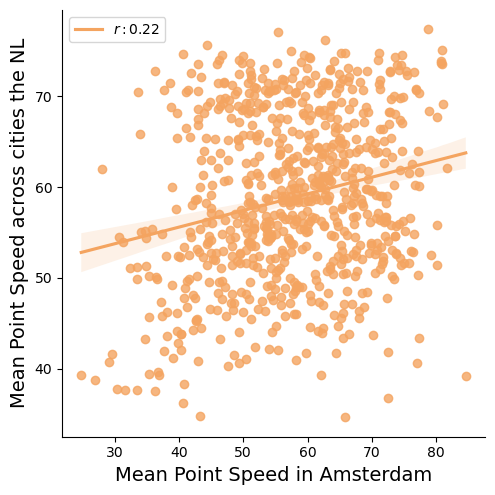

In [20]:
#  import pandas as pd 
#  import seaborn as sns
#  import matplotlib.pyplot as plt 
# import stats
# import matplotlib.pyplot as plt
from scipy import stats
# sns.set(rc = {'figure.figsize':(15,8)})
# from matplotlib import rcParams

# # figure size in inches
# rcParams['figure.figsize'] = 15,8

# sandybrown
#mediumseagreen
#cornflowerblue

# feature_x="Mean Point Speed in "
# feature_y="Mean Point Speed "
# sns.set_style("ticks")
# df = pd.read_excel('data.xlsx')
# assume some random columns called EAV and PAV in your DataFrame 
# assume a third variable used for grouping called "Mammal" which will be used for color coding
p = sns.lmplot(x=feature_x+location, y=feature_y+location1,
        data=df_outer,scatter_kws={"color": "sandybrown"},
        line_kws={'label':"Linear Reg","color":"sandybrown"}, legend=True)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
# assuming you computed r_squared which is the coefficient of determination somewhere else
slope, intercept, r_value, p_value, std_err = stats.linregress(df_outer[feature_x+location],df_outer[feature_y+location1])
label_line_1 = r'$y={0:.1f}x+{1:.1f}'.format(slope,intercept)
label_line_2 = r'$r:{0:.2f}$'.format(r_value) # as an exampple or whatever you want[!
# L_labels[0].set_text(label_line_1)
L_labels[0].set_text(label_line_2)

plt.xlabel(feature_x+location, fontsize=14)
plt.ylabel(feature_y+location1, fontsize=14)
# ax.xlabel(feature_x+location,fontsize=10)
plt.savefig(r"C:\Users\ivasu\Desktop\p1.png")
# plt.title("Normalized Braking Events - Amsterdam & the NL (Urban Roads)")

In [21]:
p_value

6.470270154322631e-10

c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

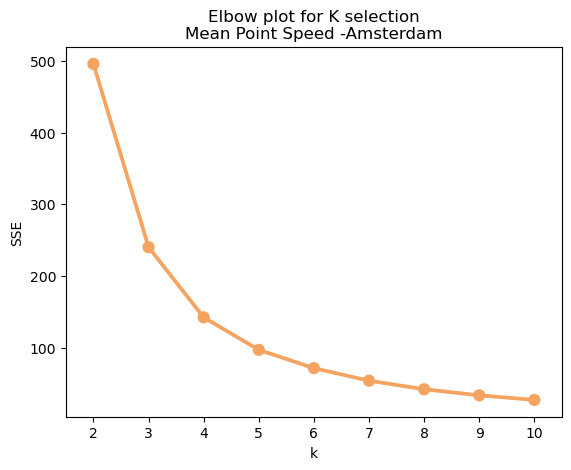

c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



For n_clusters = 2, silhouette score is 0.5733933168659796)


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



For n_clusters = 3, silhouette score is 0.5561328692672683)


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



For n_clusters = 4, silhouette score is 0.5475123344637078)


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



For n_clusters = 5, silhouette score is 0.5341412836442071)


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



For n_clusters = 6, silhouette score is 0.5220730439057485)


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



For n_clusters = 7, silhouette score is 0.5226664783764428)


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



For n_clusters = 8, silhouette score is 0.5191258678374711)


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



For n_clusters = 9, silhouette score is 0.5269134494400638)


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

3


c:\Users\ivasu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



,Unnamed: 0,Numberplate,Point_speed,Km_travelled,Indicators = OFF,Brakes = OFF,Brakes = ON,Headway Warning (long),Headway Warning (medium),Headway Warning (short),...,norm_headway_warning(short),norm_Headway Warning = OFF,norm_Lane Departure Warning = OFF,norm_Left Indicator = ON,norm_Left Lane Departure Warning = ON,norm_Left and Right Indicator = ON,norm_Right Indicator = ON,norm_Right Lane Departure Warning = ON,City,Clusters
0,0,BBRX80,57.165049,223.600,0,0,0,300,31,70,...,0.313059,1.135957,0.084973,0.000000,0.031306,0.000000,0.000000,0.049195,Amsterdam,2
1,1,BBSN73,63.705882,163.984,0,0,0,47,50,53,...,0.323202,0.207337,0.018294,0.000000,0.006098,0.000000,0.000000,0.012196,Amsterdam,1
2,2,BBXH49,68.750000,64.727,144,30,28,50,7,8,...,0.123596,0.726127,0.077248,0.911521,0.015450,1.050566,0.278091,0.061798,Amsterdam,1
3,5,BFHD67,59.322581,246.842,0,0,0,245,45,12,...,0.048614,0.996589,0.230917,0.000000,0.016205,0.000000,0.000000,0.214712,Amsterdam,2
4,6,BFRT22,42.835165,163.644,0,0,0,176,29,42,...,0.256655,0.959400,0.317763,0.000000,0.012222,0.000000,0.000000,0.305541,Amsterdam,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,756,NNB302,72.667506,23552.713,0,0,0,3466,779,281,...,0.011931,0.142744,0.092176,0.000000,0.009595,0.000000,0.000000,0.081519,Amsterdam_complete,1
757,757,NNB320,62.992343,11559.807,0,0,0,2569,612,522,...,0.045156,0.206664,0.087199,0.000000,0.013582,0.000000,0.000000,0.069032,Amsterdam_complete,1
758,758,NNB35,67.087392,9371.739,0,0,0,6344,842,1194,...,0.127404,0.670420,0.123136,0.000000,0.013445,0.000000,0.000000,0.099875,Amsterdam_complete,1
759,759,NNB404,68.499091,5721.970,0,0,0,818,241,119,...,0.020797,0.130200,0.068683,0.000000,0.008389,0.000000,0.000000,0.056449,Amsterdam_complete,1


In [22]:
class Clustering:
    def __init__(self,feature,feature_name,df,increment,decrement):
        self.feature = feature
        self.feature_name = feature_name
        self.df=df
        self.increment =increment
        self.decrement =decrement
        
    def preprocess(self,df):
        """Preprocess data for KMeans clustering"""
    
        data = np.array(self.df[self.feature])
        data=data.reshape(-1, 1)
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
        
        return data
    
    
    def elbow_plot(self):
        """Create elbow plot from normalized data"""
        data=self.preprocess(self.df)
        sse = {}
        
        for k in range(2,11):
            kmeans = KMeans(n_clusters=k, random_state=1)
            kmeans.fit(data)
            sse[k] = kmeans.inertia_
        
        plt.title('Elbow plot for K selection'+"\n"+feature_name+'-'+ city_name)
        plt.xlabel('k')
        plt.ylabel('SSE')
        sns.pointplot(x=list(sse.keys()),y=list(sse.values()),color="sandybrown")
        plt.show()
        
        
    def silhouette_coeff(self):
        """Checking silhouette score"""
        data=self.preprocess(self.df)
        range_n_clusters = range(2,10)
        
        for n_clusters in range_n_clusters:
            clusterer = KMeans(n_clusters=n_clusters)
            preds = clusterer.fit_predict(data)
            centers = clusterer.cluster_centers_

            score = silhouette_score(data, preds)
            print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
            
            
    def find_k(self):
        """Find the optimum k clusters"""
        
        data=self.preprocess(self.df)
        sse = {}
        
        for k in range(2, 21):
            kmeans = KMeans(n_clusters=k, random_state=1)
            kmeans.fit(data)
            sse[k] = kmeans.inertia_
        
        kn = KneeLocator(x=list(sse.keys()), 
                    y=list(sse.values()), 
                    curve='convex', 
                    direction='decreasing')
        k = kn.knee + self.increment - self.decrement
        return k
    
    
    def run_kmeans(self):
        """Run KMeans clustering, including the preprocessing of the data
        and the automatic selection of the optimum k. 
        """

        data=self.preprocess(self.df)
        k = self.find_k()
        print(k)
        kmeans = KMeans(n_clusters=k,init='k-means++')
        x=kmeans.fit_predict(data)
        return self.df.assign(Clusters=kmeans.labels_)
    

clustering_kmeans = Clustering(feature,feature_name,df_grouped_cities,increment=0, decrement=2) # increase or decrease number of assigned clusters using `increment` or `decrement`
clustering_kmeans.elbow_plot() 
clustering_kmeans.silhouette_coeff()
Clusters=clustering_kmeans.run_kmeans()
Clusters
# df_grouped_cities

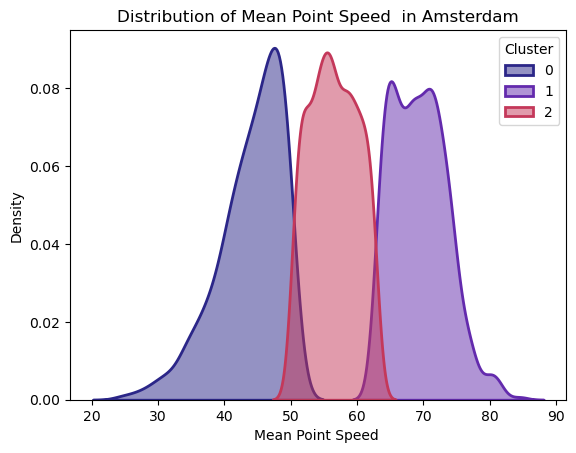

In [23]:
def viz_classes():
    sns.set_palette("CMRmap")
    sns.kdeplot(Clusters[Clusters['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==5][feature],label="5",fill=True,alpha=0.5,linewidth=2)
    plt.legend(title="Cluster")
    plt.title(r"Distribution of "+feature_name+" in "+ city_name)
    # plt.title(r"Distribution of "+feature_name+" in "+ city_name + "\n"+" and the NL (Urban Roads) - Clusters")
    plt.xlabel(feature_name)
    
viz_classes()

In [24]:
df_intra_city.columns

Index(['Unnamed: 0', 'Numberplate', 'Point_speed', 'Km_travelled',
       ' Indicators = OFF', 'Brakes = OFF', 'Brakes = ON',
       'Headway Warning (long)', 'Headway Warning (medium)',
       'Headway Warning (short)', 'Headway Warning = OFF',
       'Lane Departure Warning = OFF', 'Left Indicator = ON',
       'Left Lane Departure Warning = ON', 'Left and Right Indicator = ON',
       'Right Indicator = ON', 'Right Lane Departure Warning = ON',
       'norm_Indicators = OFF', 'norm_brakes = OFF', 'norm_brakes = ON',
       'norm_headway_warning(long)', 'norm_headway_warning(medium)',
       'norm_headway_warning(short)', 'norm_Headway Warning = OFF',
       'norm_Lane Departure Warning = OFF', 'norm_Left Indicator = ON',
       'norm_Left Lane Departure Warning = ON',
       'norm_Left and Right Indicator = ON', 'norm_Right Indicator = ON',
       'norm_Right Lane Departure Warning = ON', 'City'],
      dtype='object')

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\3568804479.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\3568804479.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\3568804479.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ivasu\AppData\Local\Temp\ipyker

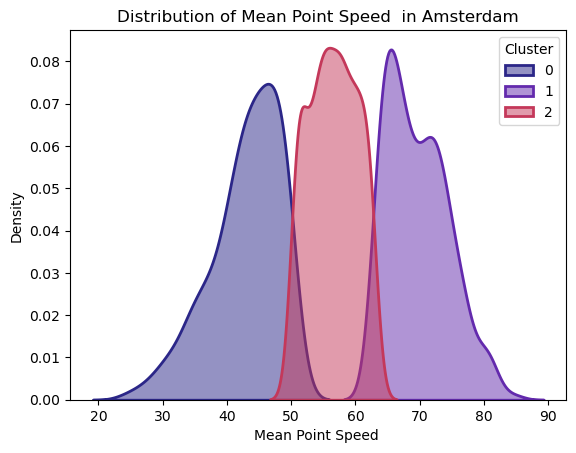

In [25]:

def processing_data_plots(df_clusters):
    df_city=df_clusters.loc[df_clusters['City'] == city_name]
    df_not_city=df_clusters.loc[df_clusters['City'] == city_name+"_complete"]
    
    sns.set_palette("CMRmap")
    sns.kdeplot(df_city[df_city['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
    plt.legend(title="Cluster")
    plt.title(r"Distribution of "+ feature_name+" in "+city_name)
    plt.xlabel(feature_name)
    
    
    df_city.drop([' Indicators = OFF',
       'Brakes = OFF', 'Brakes = ON', 'Headway Warning (long)',
       'Headway Warning (medium)', 'Headway Warning (short)',
       'Headway Warning = OFF', 'Lane Departure Warning = OFF',
       'Left Indicator = ON', 'Left Lane Departure Warning = ON',
       'Left and Right Indicator = ON', 'Right Indicator = ON',
       'Right Lane Departure Warning = ON','norm_Indicators = OFF','norm_brakes = OFF','norm_Headway Warning = OFF','norm_Left Indicator = ON', 'norm_Left and Right Indicator = ON', 'norm_Right Indicator = ON'], axis = 1, inplace = True) 
    
    
    df_not_city.drop([ 
       'Brakes = OFF', 'Brakes = ON', 'Headway Warning (long)',
       'Headway Warning (medium)', 'Headway Warning (short)',
       'Headway Warning = OFF', 'Lane Departure Warning = OFF',
       'Left Indicator = ON', 'Left Lane Departure Warning = ON',
       'Left and Right Indicator = ON', 'Right Indicator = ON',
       'Right Lane Departure Warning = ON','norm_Indicators = OFF','norm_brakes = OFF','norm_Headway Warning = OFF','norm_Left Indicator = ON', 'norm_Left and Right Indicator = ON', 'norm_Right Indicator = ON'], axis = 1, inplace = True) 
    
    df_city.reset_index(drop=True)
    df_city['Numberplate'] = df_city['Numberplate'].astype(str)
    df_city['City'] = df_city['City'].astype(str)
    df_not_city['Numberplate'] = df_not_city['Numberplate'].astype(str)
    df_not_city['City'] = df_not_city['City'].astype(str)
    
    return df_city,df_not_city

    
df_city,df_not_city=processing_data_plots(Clusters)

Text(0.5, 0, 'Cluster')

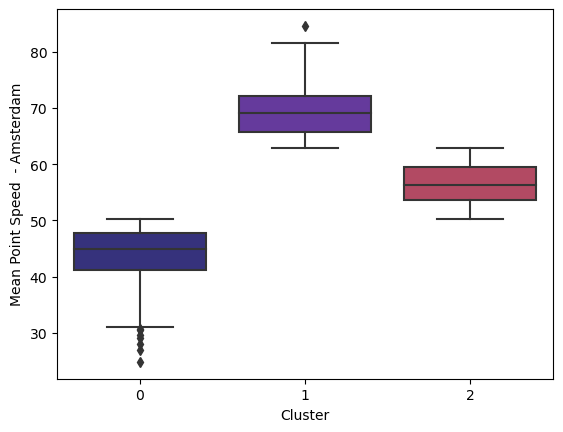

In [26]:
import matplotlib as mpl
sns.set_palette("CMRmap")
ax = sns.boxplot(x=Clusters['Clusters'],y=Clusters[feature],fliersize=5)
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.7))

plt.ylabel(feature_name+" - "+ city_name)
# plt.ylabel(feature_name)
plt.xlabel("Cluster")


In [27]:
df_city_cluster0=df_city[df_city['Clusters']==0]
df_city_cluster0_nums=list(df_city_cluster0['Numberplate'])

df_city_cluster1=df_city[df_city['Clusters']==1]
df_city_cluster1_nums=list(df_city_cluster1['Numberplate'])

df_city_cluster2=df_city[df_city['Clusters']==2]
df_city_cluster2_nums=list(df_city_cluster2['Numberplate'])

df_city_cluster3=df_city[df_city['Clusters']==3]
df_city_cluster3_nums=list(df_city_cluster3['Numberplate'])

df_city_cluster4=df_city[df_city['Clusters']==4]
df_city_cluster4_nums=list(df_city_cluster4['Numberplate'])

df_city_cluster5=df_city[df_city['Clusters']==5]
df_city_cluster5_nums=list(df_city_cluster5['Numberplate'])

In [28]:
%%capture
df_not_city_cluster0_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster0_nums)]
df_not_city_cluster0_nums['Cluster_city']=0
df_not_city_cluster1_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster1_nums)]
df_not_city_cluster1_nums['Cluster_city']=1
df_not_city_cluster2_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster2_nums)]
df_not_city_cluster2_nums['Cluster_city']=2
df_not_city_cluster3_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster3_nums)]
df_not_city_cluster3_nums['Cluster_city']=3
df_not_city_cluster4_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster4_nums)]
df_not_city_cluster4_nums['Cluster_city']=4


In [29]:
list_of_dataframes=[df_not_city_cluster0_nums,df_not_city_cluster1_nums,df_not_city_cluster2_nums,df_not_city_cluster3_nums]
df_not_city_new_clus = pd.concat(list_of_dataframes)
df_not_city_new_clus

,Unnamed: 0,Numberplate,Point_speed,Km_travelled,Indicators = OFF,norm_brakes = ON,norm_headway_warning(long),norm_headway_warning(medium),norm_headway_warning(short),norm_Lane Departure Warning = OFF,norm_Left Lane Departure Warning = ON,norm_Right Lane Departure Warning = ON,City,Clusters,Cluster_city
4,4,BFRT22,53.211651,10274.932,0,0.000000,0.812560,0.148517,0.220342,0.315623,0.022774,0.289442,Amsterdam_complete,2,0
7,7,BFSR24,49.714791,24496.485,13781,0.240769,0.658543,0.134305,0.231503,0.182557,0.024167,0.156063,Amsterdam_complete,0,0
11,11,BGHH82,34.795677,13051.504,12045,0.227483,0.002375,0.000000,0.297054,0.007126,0.000000,0.000000,Amsterdam_complete,0,0
12,12,BGRV04,57.061736,23019.860,17405,0.177455,0.549699,0.062337,0.081147,0.166639,0.010686,0.152738,Amsterdam_complete,2,0
13,13,BHBZ85,46.292171,14647.999,21860,0.413435,0.693200,0.078372,0.123839,0.085814,0.033315,0.047310,Amsterdam_complete,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,744,BVRS34,68.219709,8017.581,0,0.000000,0.104645,0.036669,0.015715,0.054006,0.007858,0.043405,Amsterdam_complete,1,2
747,747,BVRT98,68.776073,8403.248,0,0.000000,0.115670,0.023324,0.018088,0.064737,0.007259,0.052718,Amsterdam_complete,1,2
749,749,BVRV04,70.691584,7909.319,0,0.000000,0.103802,0.026677,0.009735,0.085342,0.014413,0.070423,Amsterdam_complete,1,2
754,754,NNB288,53.105167,6081.446,0,0.000000,0.279374,0.140427,0.113295,0.044726,0.012826,0.021376,Amsterdam_complete,2,2


Text(0.5, 1.0, 'Mean Point Speed  of corresponding \nvehicles based on cluster assigned in Amsterdam')

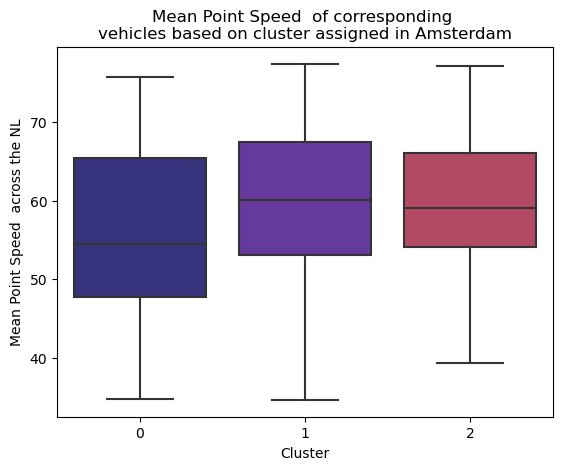

In [30]:
import matplotlib as mpl
ax = sns.boxplot(x=df_not_city_new_clus['Cluster_city'],y=df_not_city_new_clus[feature],fliersize=5)
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.7))
    
plt.ylabel(feature_name+" across the NL")
plt.xlabel("Cluster")
plt.title(feature_name+ " of corresponding "+"\n"+r"vehicles based on cluster assigned in "+city_name)
# plt.ylim(-0.1,1.4)

In [31]:
df_outer = pd.merge(df_city, df_not_city_new_clus, on='Numberplate', how='inner') #here Numberplate is common column
df_outer

,Unnamed: 0_x,Numberplate,Point_speed_x,Km_travelled_x,norm_brakes = ON_x,norm_headway_warning(long)_x,norm_headway_warning(medium)_x,norm_headway_warning(short)_x,norm_Lane Departure Warning = OFF_x,norm_Left Lane Departure Warning = ON_x,...,norm_brakes = ON_y,norm_headway_warning(long)_y,norm_headway_warning(medium)_y,norm_headway_warning(short)_y,norm_Lane Departure Warning = OFF_y,norm_Left Lane Departure Warning = ON_y,norm_Right Lane Departure Warning = ON_y,City_y,Clusters_y,Cluster_city
0,0,BBRX80,57.165049,223.600,0.000000,1.341682,0.138640,0.313059,0.084973,0.031306,...,0.000000,0.870958,0.094140,0.171379,0.116441,0.027423,0.086225,Amsterdam_complete,2,2
1,1,BBSN73,63.705882,163.984,0.000000,0.286613,0.304908,0.323202,0.018294,0.006098,...,0.000000,0.334801,0.203465,0.303001,0.013429,0.003801,0.003801,Amsterdam_complete,2,1
2,2,BBXH49,68.750000,64.727,0.432586,0.772475,0.108147,0.123596,0.077248,0.015450,...,0.463403,0.766073,0.116013,0.165977,0.061100,0.026750,0.030108,Amsterdam_complete,0,1
3,5,BFHD67,59.322581,246.842,0.000000,0.992538,0.182303,0.048614,0.230917,0.016205,...,0.000000,0.714153,0.103540,0.146351,0.170541,0.041871,0.125455,Amsterdam_complete,2,2
4,6,BFRT22,42.835165,163.644,0.000000,1.075505,0.177214,0.256655,0.317763,0.012222,...,0.000000,0.812560,0.148517,0.220342,0.315623,0.022774,0.289442,Amsterdam_complete,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,897,NNB302,72.776860,264.858,0.000000,0.135922,0.045307,0.015102,0.052859,0.003776,...,0.000000,0.147159,0.033075,0.011931,0.092176,0.009595,0.081519,Amsterdam_complete,1,1
746,898,NNB320,43.442623,111.351,0.000000,0.359224,0.098787,0.152670,0.053884,0.008981,...,0.000000,0.222236,0.052942,0.045156,0.087199,0.013582,0.069032,Amsterdam_complete,1,0
747,899,NNB35,74.659091,222.154,0.000000,1.661010,0.256579,0.045014,0.193559,0.022507,...,0.000000,0.676929,0.089845,0.127404,0.123136,0.013445,0.099875,Amsterdam_complete,1,1
748,900,NNB404,49.850000,162.062,0.000000,0.098728,0.024682,0.018511,0.030852,0.000000,...,0.000000,0.142958,0.042118,0.020797,0.068683,0.008389,0.056449,Amsterdam_complete,1,0


In [32]:
df_outer.rename(columns={'Point_speed_x': 'Mean Point Speed in '+location,
                         'Point_speed_y': 'Mean Point Speed '+location1,
                         'norm_brakes = ON_x': 'Norm Braking Events in '+location,
                         'norm_brakes = ON_y': 'Norm Braking Events '+location1,
                         'norm_headway_warning(long)_x': 'Norm L(I)-HW in '+location,
                         'norm_headway_warning(long)_y': 'Norm L(I)-HW '+location1,
                         'norm_headway_warning(medium)_x': 'Norm L(II)-HW in '+location,
                         'norm_headway_warning(medium)_y': 'Norm L(II)-HW '+location1,
                         'norm_headway_warning(short)_x': 'Norm L(III)-HW in '+location,
                         'norm_headway_warning(short)_y': 'Norm L(III)-HW '+location1,
                         'norm_Right Lane Departure Warning = ON_x': 'Norm R-LDW in '+location,
                         'norm_Right Lane Departure Warning = ON_y': 'Norm R-LDW '+location1,
                         'norm_Left Lane Departure Warning = ON_x': 'Norm L-LDW in '+location,
                         'norm_Left Lane Departure Warning = ON_y': 'Norm L-LDW '+location1
                         },
          inplace=True, errors='raise')

In [33]:
feature_x= feature_name+'in '
feature_y=feature_name

In [34]:
df_outer.columns

Index(['Unnamed: 0_x', 'Numberplate', 'Mean Point Speed in Amsterdam',
       'Km_travelled_x', 'Norm Braking Events in Amsterdam',
       'Norm L(I)-HW in Amsterdam', 'Norm L(II)-HW in Amsterdam',
       'Norm L(III)-HW in Amsterdam', 'norm_Lane Departure Warning = OFF_x',
       'Norm L-LDW in Amsterdam', 'Norm R-LDW in Amsterdam', 'City_x',
       'Clusters_x', 'Unnamed: 0_y', 'Mean Point Speed across cities the NL',
       'Km_travelled_y', ' Indicators = OFF',
       'Norm Braking Events across cities the NL',
       'Norm L(I)-HW across cities the NL',
       'Norm L(II)-HW across cities the NL',
       'Norm L(III)-HW across cities the NL',
       'norm_Lane Departure Warning = OFF_y',
       'Norm L-LDW across cities the NL', 'Norm R-LDW across cities the NL',
       'City_y', 'Clusters_y', 'Cluster_city'],
      dtype='object')

In [35]:
feature_x

'Mean Point Speed in '

Text(0.5, 1.0, 'Mean Point Speed  of vehicles \nand their corresponding clusters')

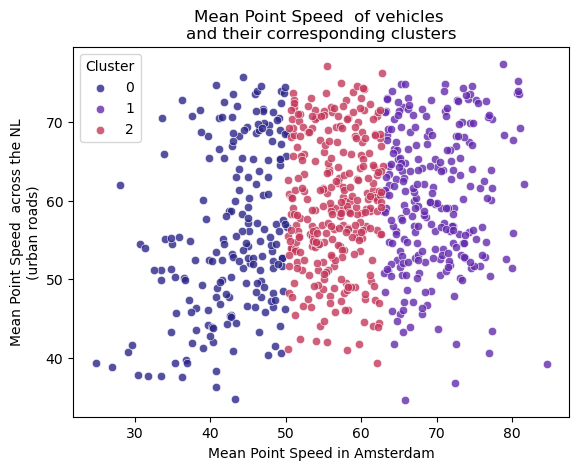

In [36]:
sns.set_palette("CMRmap")
feature_name_x="Mean Point Speed in "
feature_name_y="Mean Point Speed "
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==0],x=feature_name_x+location,y=feature_name_y+location1,alpha=0.8,label=0)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==1],x=feature_name_x+location,y=feature_name_y+location1,alpha=0.8,label=1)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==2],x=feature_name_x+location,y=feature_name_y+location1,alpha=0.8,label=2)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==3],x=feature_name_x+location,y=feature_name_y+location1,alpha=0.8,label=3)
plt.legend(title="Cluster")
plt.xlabel(feature_x+city_name)
plt.ylabel(feature_y+" across the NL" +"\n"+"(urban roads)")
plt.title(feature_y+" of vehicles "+"\n"+"and their corresponding clusters")

In [37]:
# df_outer.to_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering City\Clustering_results\df_outer_hw_norm_l1_amsterdam.csv")

In [38]:
# df_outer=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering City\Clustering_results\df_outer_hw_norm_l1_amsterdam.csv")

### Kentekens

In [39]:
kentekens=pd.read_csv(r"C:\Users\ivasu\Desktop\Robotics\2021-2022\Thesis\code\DataAnalysis\CarrierWeb\Data\kentekens_iva.csv")

In [40]:
df_outer_kentekens = pd.merge(kentekens, df_outer, on='Numberplate', how='inner') #here Numberplate is the common column
df_outer_kentekens['Power_int']=df_outer_kentekens["Power"].str[0:3]
df_outer_kentekens['Power_int'] = df_outer_kentekens['Power_int'].astype('int')

df_outer_kentekens.columns

Index(['Brand', 'Trade Name', 'Vehicle Type', 'Fuel Type', 'Registration Date',
       'Year', 'List Price', 'Apk expiry date', 'Vehicle type', 'Arrangement',
       'Color', 'Number of seats', 'Mass empty vehicle', 'Roadworthy mass',
       'Payload (Loading Capacity)', 'Max. authorized mass of vehicle',
       'Max towing mass autonomously braked', 'Max. mass to be towed braked',
       'Max. towable mass middle axle braked',
       'Max. mass to be towed uninhibited',
       'Max. towing mass of semi-trailer braked', 'Cylinder capacity',
       'Number of cylinders', 'Power', 'Fuel Type.1', 'Secondary fuel',
       'Environmental classification', 'Fuel consumption (country road)',
       'Fuel consumption (city)', 'Fuel consumption (combined)',
       'CO2 emissions combined', 'Economy label', 'Apk expiry date.1',
       'Date of initial registration',
       'Date of first issue in the Netherlands', 'Date of first registration',
       'Numberplate', 'Unnamed: 0_x', 'Mean Point Spe

In [41]:
df_outer_kentekens = df_outer_kentekens.drop(df_outer_kentekens[df_outer_kentekens['Cylinder capacity']=='onbekend'].index)
df_outer_kentekens['Cylinder capacity']=df_outer_kentekens["Cylinder capacity"].str[0:5]
df_outer_kentekens['Cylinder_capacity_int'] = df_outer_kentekens['Cylinder capacity'].astype('int')

In [42]:
bic_df=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Other Tables\BCI - Copy.csv",delimiter=';', encoding='unicode_escape')
bic_df

,Id,AOSNumber,VoucherID (kenteken),Numberplate,Chassis Number,Transporter,Location,Brand,Type,Structure,...,SW_version,nr_axles,Location_LO,Location_LA,Combination,Tank,MotowWagen_TrOp,AOS_type_nr,UseMe,Company Report
0,1,3188.0,235278.0,BRXR02,XLRAE45BF0L319751,Wim Bosman,s Heerenberg,DAF,FA LF 55,Bakwagen < 12000,...,SW_2E30,2 axles,6.252778,51.877500,Motorwagen,niet-tank,Motorwagen,1.0,1.0,0.0
1,2,3189.0,235279.0,BRXR04,XLRAE45BF0L319752,Wim Bosman,s Heerenberg,DAF,FA LF 55,Bakwagen < 12000,...,SW_2E30,2 axles,6.252778,51.877500,Motorwagen,niet-tank,Motorwagen,1.0,1.0,0.0
2,3,3190.0,235280.0,BSXL28,XLRAE75PC0E751917,Wim Bosman,s Heerenberg,DAF,FA CF 75,Motorwagen 2-assig,...,SW_2E39,2 axles,6.252778,51.877500,Motorwagen,niet-tank,Motorwagen,1.0,1.0,0.0
3,4,3191.0,235281.0,BSXL30,XLRAE75PC0E752148,Wim Bosman,s Heerenberg,DAF,FA CF 75,Motorwagen 2-assig,...,SW_2E39,2 axles,6.252778,51.877500,Motorwagen,niet-tank,Motorwagen,1.0,1.0,0.0
4,5,3192.0,235282.0,BTVJ15,XLRAE55FF0L338917,Wim Bosman,s Heerenberg,DAF,FA LF 55,Bakwagen < 12000,...,SW_,2 axles,6.252778,51.877500,Motorwagen,niet-tank,Motorwagen,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,1891,1.0,206082.0,BTJR66,YS2P4X20002031767,Adriaanse,Raamsdonksveer,Scania,P 380 LA 4x2 MNA 370,Trekker 2-assig,...,SW_2E39,2 axles,4.873611,51.696667,Trekker-Oplegger,niet-tank,Trekker-Oplegger,3.0,1.0,0.0
1891,1892,2587.0,206100.0,BSXX56,WMAH922206L042507,Van Noort,Waddinxveen,Volvo,FM 340,Trekker 2-assig,...,SW_2E39,2 axles,4.651389,52.045000,Trekker-Oplegger,niet-tank,Trekker-Oplegger,3.0,1.0,1.0
1892,1893,3097.0,208046.0,BTDX76,NaN,Blok,Hellevoetsluis,Volvo,FH 400,Niet bekend,...,SW_2E39,unknown,4.133333,51.833333,Niet bekend,onbekend,Niet bekend,3.0,1.0,0.0
1893,1894,2581.0,208048.0,BRHD76,WMAH06ZZ85M420485,Van Noort,Waddinxveen,Man,TGA 18 4x2,Bakwagen 2-assig,...,SW_,2 axles,4.651389,52.045000,Motorwagen,niet-tank,Motorwagen,3.0,1.0,1.0


In [43]:
df_city_cluster_true_kentekens_more_info= pd.merge(df_outer_kentekens, bic_df, on='Numberplate', how='inner') #here Numberplate is common column

In [44]:
"""
Important columns

- Year
- Mass empty vehicle
- Brand
- Transporter

"""

'\nImportant columns\n\n- Year\n- Mass empty vehicle\n- Brand\n- Transporter\n\n'

In [45]:
df = df_city_cluster_true_kentekens_more_info[['Numberplate','Brand_x','Year','Mass empty vehicle','Cylinder capacity','Power_int','Transporter']]


In [46]:
feature_y

'Mean Point Speed '

In [47]:
df_discussion = pd.merge(df, df_outer, on='Numberplate', how='inner') #here Numberplate is the common column
df_discussion

,Numberplate,Brand_x,Year,Mass empty vehicle,Cylinder capacity,Power_int,Transporter,Unnamed: 0_x,Mean Point Speed in Amsterdam,Km_travelled_x,...,Norm Braking Events across cities the NL,Norm L(I)-HW across cities the NL,Norm L(II)-HW across cities the NL,Norm L(III)-HW across cities the NL,norm_Lane Departure Warning = OFF_y,Norm L-LDW across cities the NL,Norm R-LDW across cities the NL,City_y,Clusters_y,Cluster_city
0,BTHB53,DAF,2007,7644 kg,12902,300,Nabuurs Transport,646,61.674419,86.818,...,0.000000,0.620721,0.099907,0.157768,0.251632,0.008808,0.236266,Amsterdam_complete,1,2
1,BSNF22,MAN,2006,6981 kg,10518,294,Nabuurs Transport,450,65.797619,333.861,...,0.000000,0.765608,0.107540,0.170851,0.174268,0.040940,0.127977,Amsterdam_complete,2,1
2,BSNF40,MAN,2006,6981 kg,10518,294,Nabuurs Transport,455,56.561404,321.493,...,0.000000,0.735434,0.025887,0.144944,0.006317,0.000000,0.000000,Amsterdam_complete,2,2
3,BSNF59,MAN,2006,6981 kg,10518,294,Nabuurs Transport,460,69.160000,107.643,...,0.000000,0.660807,0.194691,0.190668,0.180855,0.036002,0.140406,Amsterdam_complete,2,1
4,BSNF68,MAN,2006,6981 kg,10518,294,Nabuurs Transport,462,68.352000,254.520,...,0.000000,0.830233,0.109163,0.217378,0.206884,0.027983,0.171760,Amsterdam_complete,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,BPSJ77,SCANIA,2004,8930 kg,8867,169,VT Verkerk,164,84.589041,1246.885,...,0.989018,1.423659,0.277795,0.400038,0.356380,0.060555,0.284667,Amsterdam_complete,0,1
496,BRLS64,SCANIA,2005,8285 kg,10640,280,VT Verkerk,268,70.088889,91.470,...,0.550604,0.764027,0.281973,0.227966,0.383897,0.058734,0.322398,Amsterdam_complete,2,1
497,BRPP52,SCANIA,2005,8940 kg,8867,169,VT Verkerk,288,72.456522,1513.120,...,0.583968,0.850892,0.130730,0.184015,0.160478,0.025028,0.128929,Amsterdam_complete,0,1
498,BSNX42,SCANIA,2006,9750 kg,8867,169,VT Verkerk,478,60.365217,228.121,...,0.357622,0.563447,0.014357,0.087527,0.004786,0.000000,0.000000,Amsterdam_complete,0,2


In [48]:
df_discussion['Mass_empty_vehicle_int']=df_discussion["Mass empty vehicle"].str[0:5]
df_discussion['Mass_empty_vehicle_int'] = df_discussion['Mass_empty_vehicle_int'].astype('int')
df_discussion['Year'] = df_discussion['Year'].astype('int')

In [49]:
df_discussion['cluster_comp'] = np.where(df_discussion['Clusters_x']==df_discussion['Clusters_y'], 'True', 'False')

In [50]:
a=df_discussion[df_discussion['cluster_comp']=='True']
# a['clusters_utrecht'].value_counts()
len(df_discussion[df_discussion['cluster_comp']=='True'])/len(df_discussion)*100

40.6

In [51]:
a['Clusters_x'].value_counts()/len(a)*100

2    49.261084
1    31.527094
0    19.211823
Name: Clusters_x, dtype: float64

In [52]:
df_discussion_cluster1=df_discussion[df_discussion['Clusters_x']==1]
df_discussion_cluster1

,Numberplate,Brand_x,Year,Mass empty vehicle,Cylinder capacity,Power_int,Transporter,Unnamed: 0_x,Mean Point Speed in Amsterdam,Km_travelled_x,...,Norm L(II)-HW across cities the NL,Norm L(III)-HW across cities the NL,norm_Lane Departure Warning = OFF_y,Norm L-LDW across cities the NL,Norm R-LDW across cities the NL,City_y,Clusters_y,Cluster_city,Mass_empty_vehicle_int,cluster_comp
1,BSNF22,MAN,2006,6981 kg,10518,294,Nabuurs Transport,450,65.797619,333.861,...,0.107540,0.170851,0.174268,0.040940,0.127977,Amsterdam_complete,2,1,6981,False
3,BSNF59,MAN,2006,6981 kg,10518,294,Nabuurs Transport,460,69.160000,107.643,...,0.194691,0.190668,0.180855,0.036002,0.140406,Amsterdam_complete,2,1,6981,False
4,BSNF68,MAN,2006,6981 kg,10518,294,Nabuurs Transport,462,68.352000,254.520,...,0.109163,0.217378,0.206884,0.027983,0.171760,Amsterdam_complete,2,1,6981,False
17,BTFH16,DAF,2007,6909 kg,12902,265,VT Verkerk,618,72.195122,253.035,...,0.196139,0.181893,0.293069,0.045176,0.245615,Amsterdam_complete,1,1,6909,True
18,BTFN43,DAF,2007,7014 kg,12902,265,VT Verkerk,622,77.377483,1559.989,...,0.105192,0.133945,0.180006,0.038396,0.137618,Amsterdam_complete,2,1,7014,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,BVFN99,VOLVO,2008,8603 kg,12780,324,Post en Haveman,803,64.044444,93.587,...,0.138133,0.174397,0.231438,0.062833,0.158405,Amsterdam_complete,0,1,8603,False
491,BPJP46,MERCEDES-BENZ,2004,8005 kg,1946,300,Nabuurs Transport,126,68.000000,310.989,...,0.113464,0.242795,0.108111,0.019500,0.078478,Amsterdam_complete,0,1,8005,False
495,BPSJ77,SCANIA,2004,8930 kg,8867,169,VT Verkerk,164,84.589041,1246.885,...,0.277795,0.400038,0.356380,0.060555,0.284667,Amsterdam_complete,0,1,8930,False
496,BRLS64,SCANIA,2005,8285 kg,10640,280,VT Verkerk,268,70.088889,91.470,...,0.281973,0.227966,0.383897,0.058734,0.322398,Amsterdam_complete,2,1,8285,False


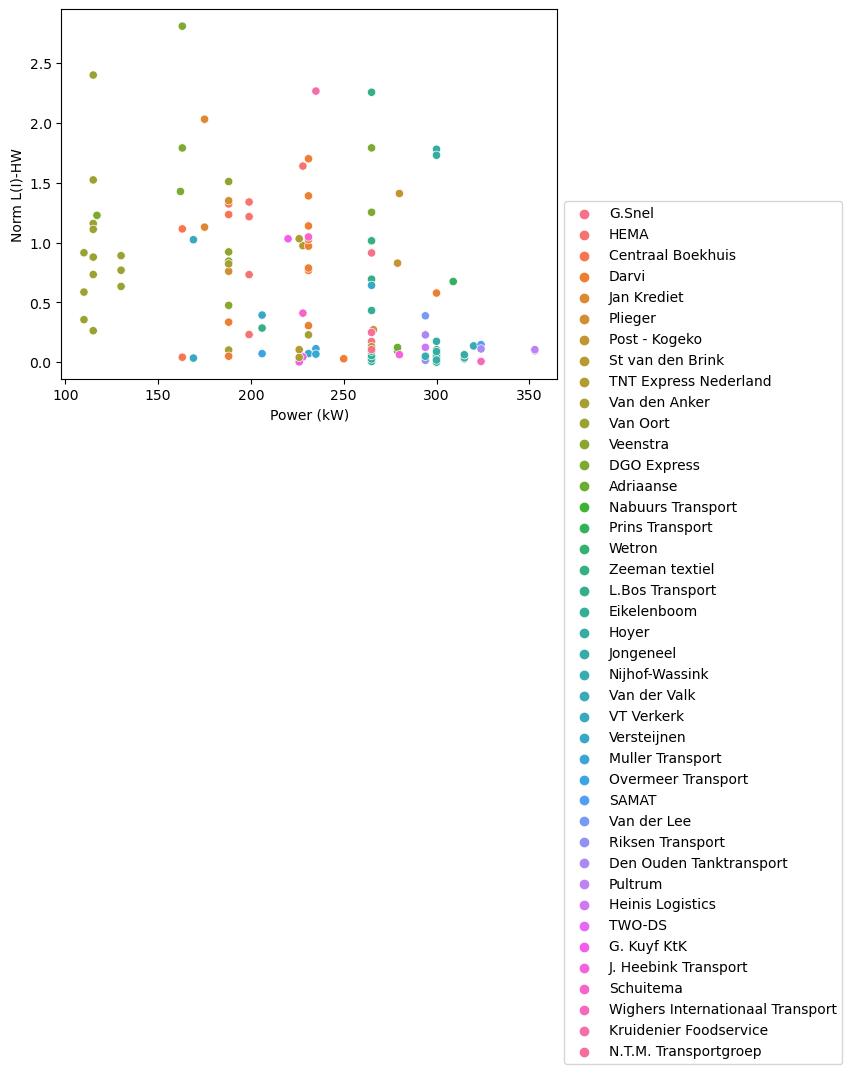

In [53]:
sns.scatterplot(data=df_discussion[df_discussion['Clusters_x']==0],x="Power_int",y="Norm L(I)-HW in "+city_name,hue='Transporter')
plt.xlabel("Power (kW)")
plt.ylabel("Norm L(I)-HW")
plt.legend(loc='best', bbox_to_anchor=(1., 0., 0.0, 0.5))

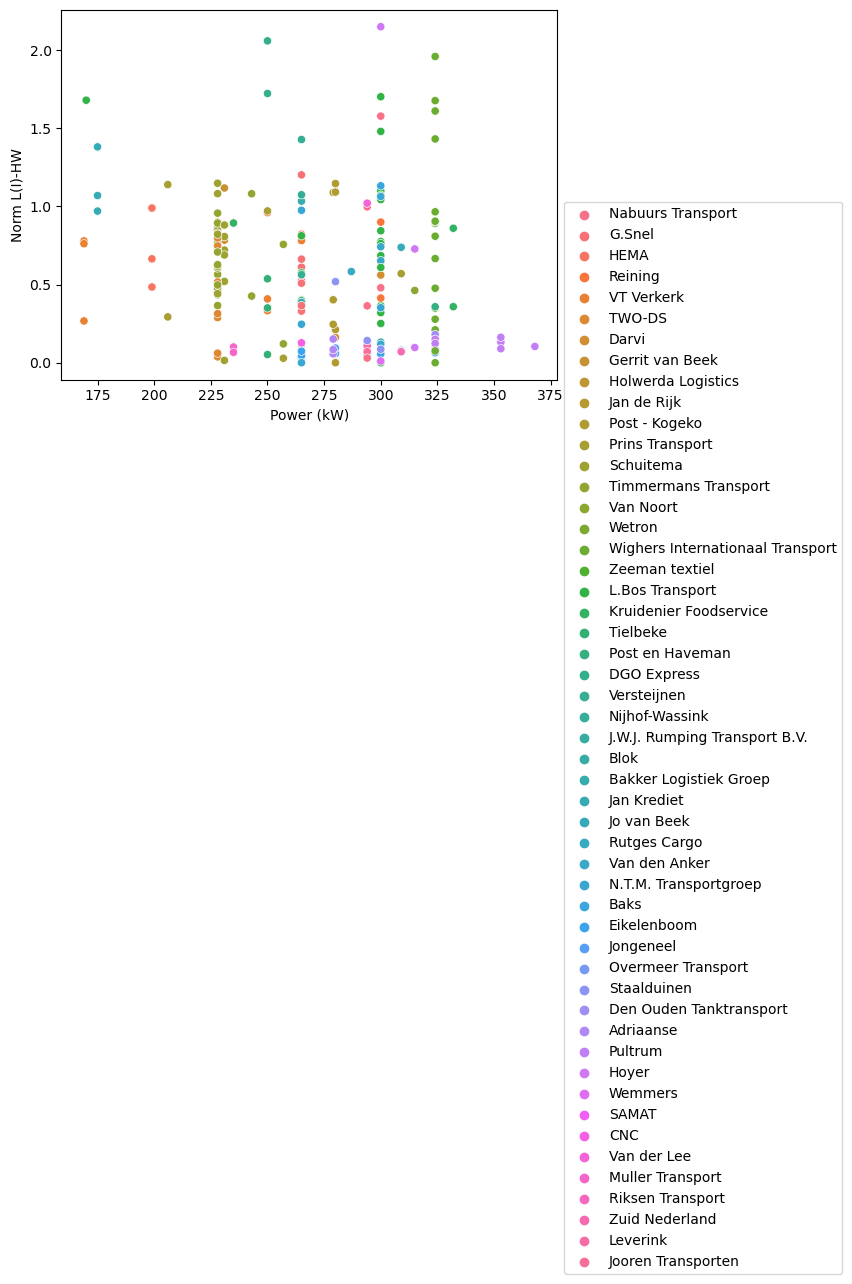

In [54]:
sns.scatterplot(data=df_discussion[df_discussion['Clusters_x']==2],x="Power_int",y="Norm L(I)-HW in "+city_name,hue='Transporter')
plt.xlabel("Power (kW)")
plt.ylabel("Norm L(I)-HW")
plt.legend(loc='best', bbox_to_anchor=(1., 0., 0.0, 0.5))

In [55]:
df_discussion['Transporter'].value_counts()

L.Bos Transport                     45
Nabuurs Transport                   29
Wighers Internationaal Transport    27
VT Verkerk                          24
Schuitema                           23
                                    ..
Heinis Logistics                     1
Roek                                 1
Van der Luyt                         1
Gerrit van Beek                      1
J. Heebink Transport                 1
Name: Transporter, Length: 72, dtype: int64

In [56]:
df_discussion_cluster1=df_discussion[df_discussion['Clusters_x']==1]
df_discussion_cluster0=df_discussion[df_discussion['Clusters_x']==0]
df_discussion_cluster2=df_discussion[df_discussion['Clusters_x']==2]
df_discussion_cluster3=df_discussion[df_discussion['Clusters_x']==3]


In [57]:
df_discussion_cluster1_transporter=df_discussion_cluster1['Transporter'].value_counts()
df_discussion_cluster0_transporter=df_discussion_cluster0['Transporter'].value_counts()
df_discussion_cluster2_transporter=df_discussion_cluster2['Transporter'].value_counts()
df_discussion_cluster3_transporter=df_discussion_cluster3['Transporter'].value_counts()

In [58]:

df_discussion_transporte_cluster_comp=df_discussion['cluster_comp'].value_counts()

In [59]:
df_discussion_transporter=df_discussion['Transporter'].value_counts()
df_discussion_transporter

L.Bos Transport                     45
Nabuurs Transport                   29
Wighers Internationaal Transport    27
VT Verkerk                          24
Schuitema                           23
                                    ..
Heinis Logistics                     1
Roek                                 1
Van der Luyt                         1
Gerrit van Beek                      1
J. Heebink Transport                 1
Name: Transporter, Length: 72, dtype: int64

In [60]:
import pandas as pd
  
# intialise data of lists.
data = {'All Transporter':df_discussion_transporter,
        'Cluster1':df_discussion_cluster1_transporter,
        'Perc_cluster1':(df_discussion_cluster1_transporter/df_discussion_transporter)*100,
        'Cluster0':df_discussion_cluster0_transporter,
        'Perc_cluster0':(df_discussion_cluster0_transporter/df_discussion_transporter)*100,
        'Cluster2':df_discussion_cluster2_transporter,
        'Perc_cluster2':(df_discussion_cluster2_transporter/df_discussion_transporter)*100,
        'Cluster3':df_discussion_cluster3_transporter,
        'Perc_cluster3':(df_discussion_cluster3_transporter/df_discussion_transporter)*100,
        'Cluster_Comp':df_discussion_transporte_cluster_comp}
  
# Create DataFrame
df = pd.DataFrame(data)
  
# Print the output.
df

,All Transporter,Cluster1,Perc_cluster1,Cluster0,Perc_cluster0,Cluster2,Perc_cluster2,Cluster3,Perc_cluster3,Cluster_Comp
ATT BV,6.0,6.0,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adriaanse,5.0,NaN,NaN,2.0,40.000000,3.0,60.000000,NaN,NaN,NaN
Albert Keizer,6.0,6.0,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bakker Logistiek Groep,2.0,NaN,NaN,NaN,NaN,2.0,100.000000,NaN,NaN,NaN
Baks,3.0,1.0,33.333333,NaN,NaN,2.0,66.666667,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Wemmers,5.0,4.0,80.000000,NaN,NaN,1.0,20.000000,NaN,NaN,NaN
Wetron,2.0,NaN,NaN,1.0,50.000000,1.0,50.000000,NaN,NaN,NaN
Wighers Internationaal Transport,27.0,10.0,37.037037,1.0,3.703704,16.0,59.259259,NaN,NaN,NaN
Zeeman textiel,6.0,1.0,16.666667,4.0,66.666667,1.0,16.666667,NaN,NaN,NaN


In [61]:
df=df.reset_index()

In [62]:
df_50_clustrer1=df[df['Perc_cluster1']>50]
list_of_vehicles_cluster1_50=list(df_50_clustrer1['index'])

df_50_clustrer1_complete_info = df_discussion[df_discussion['Transporter'].isin(list_of_vehicles_cluster1_50)]
df_50_clustrer1_complete_info=df_50_clustrer1_complete_info[df_50_clustrer1_complete_info['Cluster_city']==1]

Text(0.5, 1.0, 'Headway Warnings vs Mass of vehicle (kg)\n(Transport companies with majority of driver assigned lowest cluster)')

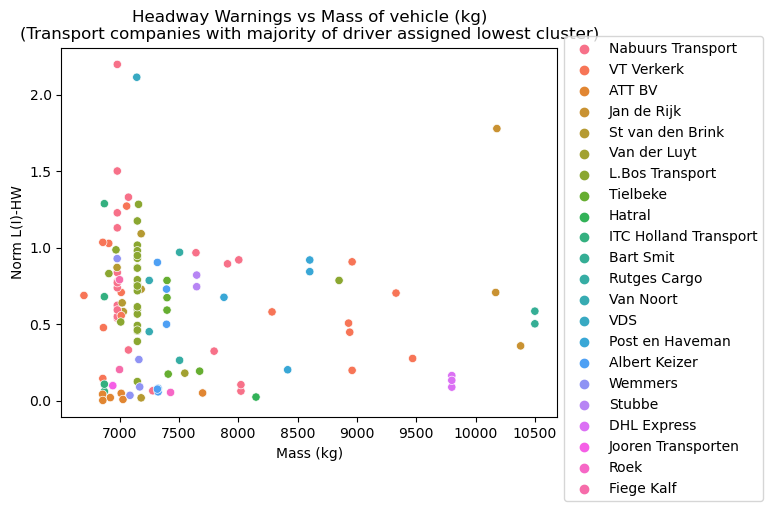

In [63]:
sns.scatterplot(data=df_50_clustrer1_complete_info,x="Mass_empty_vehicle_int",y="Norm L(I)-HW in "+city_name,hue='Transporter')
plt.xlabel("Mass (kg)")
plt.ylabel("Norm L(I)-HW")
plt.legend(loc='best', bbox_to_anchor=(1., 0.55, 0.0, 0.5))
plt.title("Headway Warnings vs Mass of vehicle (kg)"+"\n"+"(Transport companies with majority of driver assigned lowest cluster)")

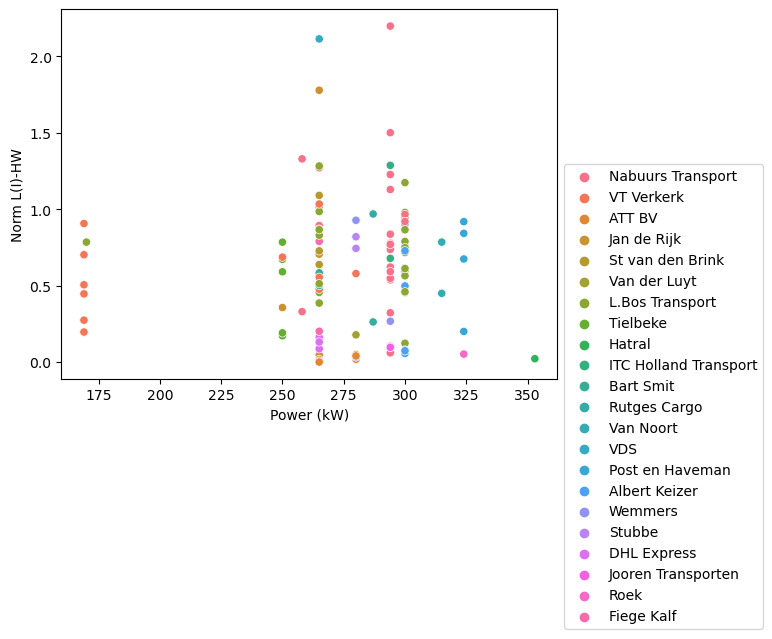

In [64]:
sns.scatterplot(data=df_50_clustrer1_complete_info,x="Power_int",y="Norm L(I)-HW in "+city_name,hue='Transporter')
plt.xlabel("Power (kW)")
plt.ylabel("Norm L(I)-HW")
plt.legend(loc='best', bbox_to_anchor=(1., 0.1, 0.0, 0.5))

In [65]:
df[df['Perc_cluster0']>50]

,index,All Transporter,Cluster1,Perc_cluster1,Cluster0,Perc_cluster0,Cluster2,Perc_cluster2,Cluster3,Perc_cluster3,Cluster_Comp
8,Centraal Boekhuis,5.0,1.0,20.000000,4.0,80.000000,NaN,NaN,NaN,NaN,NaN
9,DGO Express,9.0,1.0,11.111111,6.0,66.666667,2.0,22.222222,NaN,NaN,NaN
11,Darvi,16.0,NaN,NaN,12.0,75.000000,4.0,25.000000,NaN,NaN,NaN
12,Den Ouden Tanktransport,3.0,NaN,NaN,2.0,66.666667,1.0,33.333333,NaN,NaN,NaN
16,G. Kuyf KtK,2.0,NaN,NaN,2.0,100.000000,NaN,NaN,NaN,NaN,NaN
21,Heinis Logistics,1.0,NaN,NaN,1.0,100.000000,NaN,NaN,NaN,NaN,NaN
23,Hoyer,16.0,2.0,12.500000,11.0,68.750000,3.0,18.750000,NaN,NaN,NaN
25,J. Heebink Transport,1.0,NaN,NaN,1.0,100.000000,NaN,NaN,NaN,NaN,NaN
40,Plieger,4.0,1.0,25.000000,3.0,75.000000,NaN,NaN,NaN,NaN,NaN
54,TNT Express Nederland,6.0,2.0,33.333333,4.0,66.666667,NaN,NaN,NaN,NaN,NaN


In [66]:
df_50_clustrer0=df[df['Perc_cluster2']>50]
list_of_vehicles_cluster0_50=list(df_50_clustrer0['index'])

df_50_clustrer0_complete_info = df_discussion[df_discussion['Transporter'].isin(list_of_vehicles_cluster0_50)]
df_50_clustrer0_complete_info=df_50_clustrer0_complete_info[df_50_clustrer0_complete_info['Cluster_city']==2]
# df_50_clustrer0_complete_info

Text(0.5, 1.0, 'Headway Warnings vs Power (kW)\n(Transport companies with majority of driver assigned lowest cluster)')

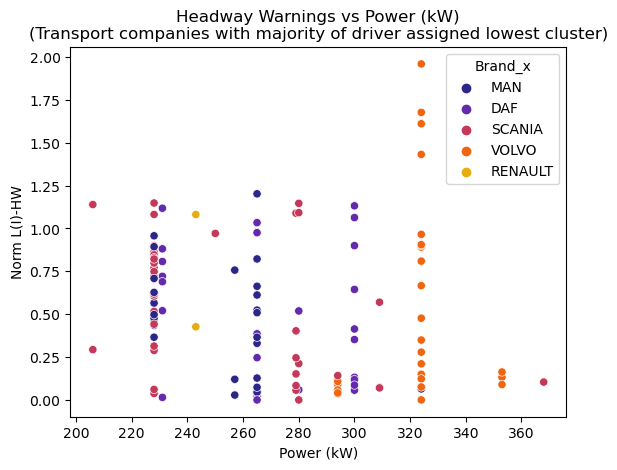

In [67]:
sns.scatterplot(data=df_50_clustrer0_complete_info,x="Power_int",y="Norm L(I)-HW in "+city_name,hue='Brand_x')
plt.xlabel("Power (kW)")
plt.ylabel("Norm L(I)-HW")
# plt.legend(loc='best', bbox_to_anchor=(1., 0.55, 0.0, 0.5))
plt.title("Headway Warnings vs Power (kW)"+"\n"+"(Transport companies with majority of driver assigned lowest cluster)")

In [68]:
df_50_clustrer0_complete_info

,Numberplate,Brand_x,Year,Mass empty vehicle,Cylinder capacity,Power_int,Transporter,Unnamed: 0_x,Mean Point Speed in Amsterdam,Km_travelled_x,...,Norm L(II)-HW across cities the NL,Norm L(III)-HW across cities the NL,norm_Lane Departure Warning = OFF_y,Norm L-LDW across cities the NL,Norm R-LDW across cities the NL,City_y,Clusters_y,Cluster_city,Mass_empty_vehicle_int,cluster_comp
7,BTDT01,MAN,2007,6783 kg,10518,265,G.Snel,604,62.069565,227.118,...,0.072165,0.111251,0.128194,0.010359,0.114408,Amsterdam_complete,2,2,6783,True
8,BTDT05,MAN,2007,6783 kg,10518,265,G.Snel,607,55.981132,208.064,...,0.070305,0.086072,0.054171,0.007599,0.042223,Amsterdam_complete,2,2,6783,True
10,BTSF52,MAN,2008,6763 kg,10518,265,G.Snel,723,59.500000,181.341,...,0.074235,0.096322,0.080639,0.022000,0.053498,Amsterdam_complete,2,2,6763,True
14,BTNS25,DAF,2008,7300 kg,12902,300,Reining,693,62.100000,79.131,...,0.087379,0.098565,0.039018,0.014804,0.019739,Amsterdam_complete,2,2,7300,True
21,BRBR92,SCANIA,2005,6550 kg,8867,228,TWO-DS,205,53.716981,204.289,...,0.080270,0.085046,0.072897,0.016004,0.053416,Amsterdam_complete,2,2,6550,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,BTFF39,DAF,2007,6854 kg,12902,265,N.T.M. Transportgroep,613,53.843137,98.587,...,0.000068,0.000342,0.027999,0.017799,0.009584,Amsterdam_complete,1,2,6854,False
487,BVBL75,DAF,2008,7319 kg,12902,300,N.T.M. Transportgroep,780,62.687500,193.111,...,0.082124,0.077521,0.179803,0.027547,0.145904,Amsterdam_complete,2,2,7319,True
489,BVDR11,DAF,2008,6859 kg,12902,265,N.T.M. Transportgroep,797,58.529412,131.215,...,0.089438,0.077626,0.088163,0.024473,0.060503,Amsterdam_complete,2,2,6859,True
493,BVFZ44,SCANIA,2008,13550 kg,9290,206,Prins Transport,809,60.441315,421.185,...,0.109422,0.159105,0.103892,0.036337,0.063624,Amsterdam_complete,0,2,13550,False


In [69]:
a=df_discussion[df_discussion['cluster_comp']=='True']
a['Cluster_city'].value_counts()

2    100
1     64
0     39
Name: Cluster_city, dtype: int64

Text(0.5, 1.0, 'Headway Warnings vs Mass of vehicle (kg)\n(Transport companies with majority of driver assigned lowest cluster)')

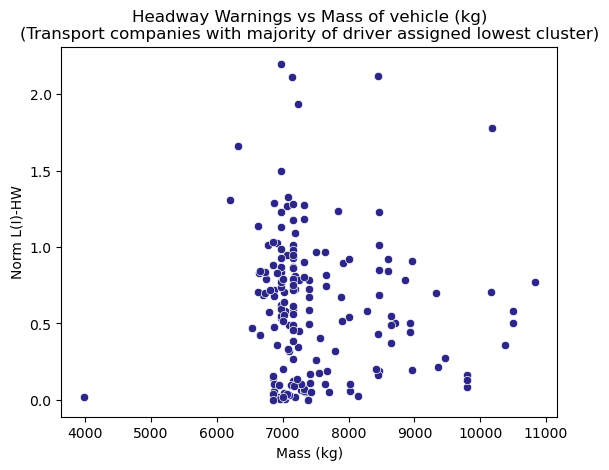

In [70]:
### Exploring indi clusters
sns.scatterplot(data=df_discussion[df_discussion['Cluster_city']==1],x="Mass_empty_vehicle_int",y="Norm L(I)-HW in "+city_name)
plt.xlabel("Mass (kg)")
plt.ylabel("Norm L(I)-HW")
# plt.legend(loc='best', bbox_to_anchor=(1., 0.55, 0.0, 0.5))
plt.title("Headway Warnings vs Mass of vehicle (kg)"+"\n"+"(Transport companies with majority of driver assigned lowest cluster)")

In [71]:
# sns.kdeplot(df_discussion['Mass_empty_vehicle_int'],hue=df_discussion['Cluster_city'],linewidth=3)

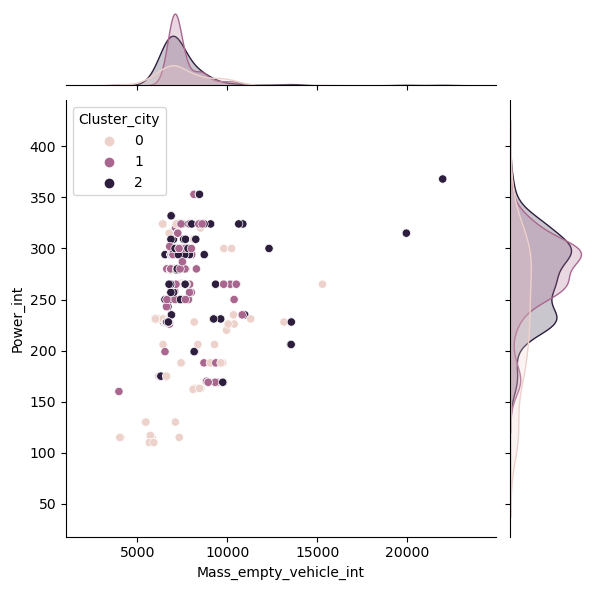

In [72]:
sns.set_palette("CMRmap")
sns.jointplot(data=df_discussion,x="Mass_empty_vehicle_int",y="Power_int",hue="Cluster_city")

Text(0.5, 0, 'Cluster')

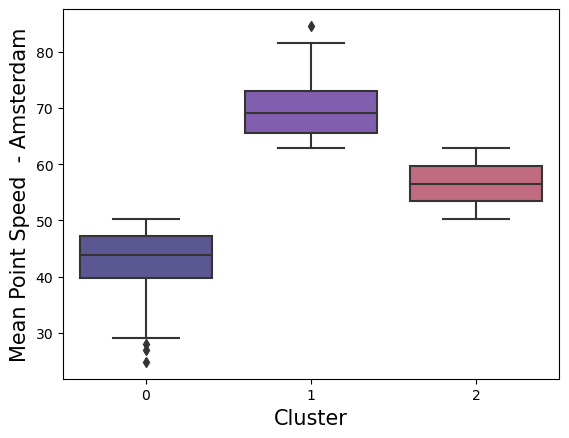

In [73]:
import matplotlib as mpl
sns.set_palette("CMRmap")
ax = sns.boxplot(x=df_city['Clusters'],y=df_city[feature],fliersize=5)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .82))

plt.ylabel(feature_name+" - "+ city_name,fontsize=15)
# plt.ylabel(feature_name)
plt.xlabel("Cluster",fontsize=15)


In [74]:
df_not_city_cluster0_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster0_nums)]
df_not_city_cluster0_nums['Cluster_city']=0
df_not_city_cluster1_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster1_nums)]
df_not_city_cluster1_nums['Cluster_city']=1
df_not_city_cluster2_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster2_nums)]
df_not_city_cluster2_nums['Cluster_city']=2
df_not_city_cluster3_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster3_nums)]
df_not_city_cluster3_nums['Cluster_city']=3
df_not_city_cluster4_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster4_nums)]
df_not_city_cluster4_nums['Cluster_city']=4

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\754105230.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\754105230.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\754105230.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [75]:
list_of_dataframes=[df_not_city_cluster0_nums,df_not_city_cluster1_nums,df_not_city_cluster2_nums,df_not_city_cluster3_nums]
df_not_city_new_clus = pd.concat(list_of_dataframes)
df_not_city_new_clus

,Unnamed: 0,Numberplate,Point_speed,Km_travelled,Indicators = OFF,norm_brakes = ON,norm_headway_warning(long),norm_headway_warning(medium),norm_headway_warning(short),norm_Lane Departure Warning = OFF,norm_Left Lane Departure Warning = ON,norm_Right Lane Departure Warning = ON,City,Clusters,Cluster_city
4,4,BFRT22,53.211651,10274.932,0,0.000000,0.812560,0.148517,0.220342,0.315623,0.022774,0.289442,Amsterdam_complete,2,0
7,7,BFSR24,49.714791,24496.485,13781,0.240769,0.658543,0.134305,0.231503,0.182557,0.024167,0.156063,Amsterdam_complete,0,0
11,11,BGHH82,34.795677,13051.504,12045,0.227483,0.002375,0.000000,0.297054,0.007126,0.000000,0.000000,Amsterdam_complete,0,0
12,12,BGRV04,57.061736,23019.860,17405,0.177455,0.549699,0.062337,0.081147,0.166639,0.010686,0.152738,Amsterdam_complete,2,0
13,13,BHBZ85,46.292171,14647.999,21860,0.413435,0.693200,0.078372,0.123839,0.085814,0.033315,0.047310,Amsterdam_complete,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,744,BVRS34,68.219709,8017.581,0,0.000000,0.104645,0.036669,0.015715,0.054006,0.007858,0.043405,Amsterdam_complete,1,2
747,747,BVRT98,68.776073,8403.248,0,0.000000,0.115670,0.023324,0.018088,0.064737,0.007259,0.052718,Amsterdam_complete,1,2
749,749,BVRV04,70.691584,7909.319,0,0.000000,0.103802,0.026677,0.009735,0.085342,0.014413,0.070423,Amsterdam_complete,1,2
754,754,NNB288,53.105167,6081.446,0,0.000000,0.279374,0.140427,0.113295,0.044726,0.012826,0.021376,Amsterdam_complete,2,2


Text(0.5, 1.0, 'Mean Point Speed  of corresponding \nvehicles based on cluster assigned in Amsterdam')

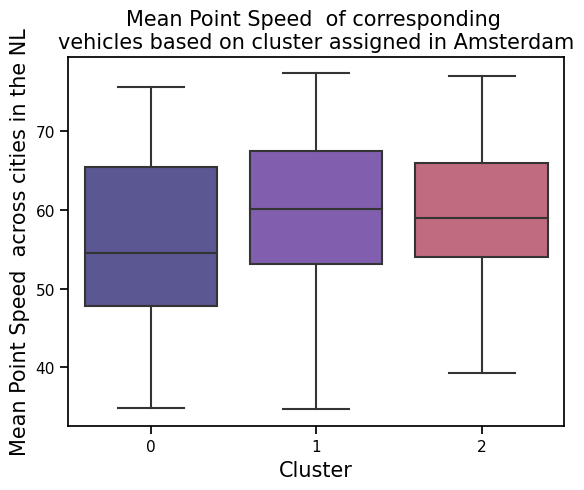

In [76]:
import matplotlib as mpl
sns.set_context("notebook")
ax = sns.boxplot(x=df_not_city_new_clus['Cluster_city'],y=df_not_city_new_clus[feature],fliersize=5)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .82))
    
plt.ylabel(feature_name+" across cities in the NL",fontsize=15)
plt.xlabel("Cluster",fontsize=15)
plt.title(feature_name+ " of corresponding "+"\n"+r"vehicles based on cluster assigned in "+city_name,fontsize=15)

In [77]:
# df_discussion[df_discussion['Cluster_city']==0]['Power_int'].median()
df_discussion[df_discussion['Cluster_city']==0]['Mass_empty_vehicle_int'].median()
# Mass_empty_vehicle_int

7230.0

In [78]:
# df_discussion[df_discussion['Cluster_city']==1]['Power_int'].median()
df_discussion[df_discussion['Cluster_city']==1]['Mass_empty_vehicle_int'].median()

7150.0

In [79]:
# df_discussion[df_discussion['Cluster_city']==2]['Power_int'].median()
df_discussion[df_discussion['Cluster_city']==2]['Mass_empty_vehicle_int'].median()

7150.0

In [80]:
df_discussion[df_discussion['Cluster_city']==3]['Power_int'].median()
# df_discussion[df_discussion['Cluster_city']==3]['Mass_empty_vehicle_int'].median()

nan

Text(0.5, 1.0, 'Engine Power of different clusters in Amsterdam\n(Feature for clustering - Mean Point Speed )')

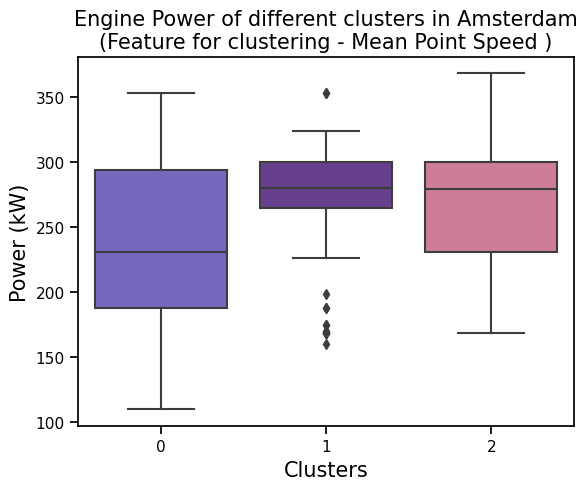

In [81]:
palette_2 = sns.color_palette(["slateblue","rebeccapurple","palevioletred","coral"])
# palette_2
sns.boxplot(x=df_discussion['Cluster_city'],y=df_discussion['Power_int'],palette=palette_2)
plt.ylabel("Power (kW)",fontsize=15)
plt.xlabel("Clusters",fontsize=15)
plt.title("Engine Power of different clusters in Amsterdam"+"\n"+"(Feature for clustering - "+ feature_name+")",fontsize=15)

In [82]:
df_discussion.columns

Index(['Numberplate', 'Brand_x', 'Year', 'Mass empty vehicle',
       'Cylinder capacity', 'Power_int', 'Transporter', 'Unnamed: 0_x',
       'Mean Point Speed in Amsterdam', 'Km_travelled_x',
       'Norm Braking Events in Amsterdam', 'Norm L(I)-HW in Amsterdam',
       'Norm L(II)-HW in Amsterdam', 'Norm L(III)-HW in Amsterdam',
       'norm_Lane Departure Warning = OFF_x', 'Norm L-LDW in Amsterdam',
       'Norm R-LDW in Amsterdam', 'City_x', 'Clusters_x', 'Unnamed: 0_y',
       'Mean Point Speed across cities the NL', 'Km_travelled_y',
       ' Indicators = OFF', 'Norm Braking Events across cities the NL',
       'Norm L(I)-HW across cities the NL',
       'Norm L(II)-HW across cities the NL',
       'Norm L(III)-HW across cities the NL',
       'norm_Lane Departure Warning = OFF_y',
       'Norm L-LDW across cities the NL', 'Norm R-LDW across cities the NL',
       'City_y', 'Clusters_y', 'Cluster_city', 'Mass_empty_vehicle_int',
       'cluster_comp'],
      dtype='object')

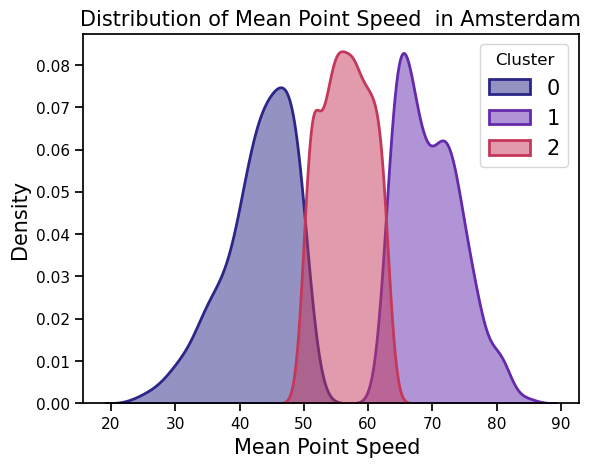

In [83]:
def viz_classes():
    sns.set_palette("CMRmap")
    sns.kdeplot(df_city[df_city['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==5][feature],label="5",fill=True,alpha=0.5,linewidth=2)
    plt.legend(title="Cluster",fontsize=15)
    # plt.title(r"Distribution of "+feature_name+" in "+ city_name)
    plt.title(r"Distribution of "+feature_name+" in "+ city_name,fontsize=15)
    plt.xlabel(feature_name,fontsize=15)
    plt.ylabel("Density",fontsize=15)
viz_classes()

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\883188700.py:5: UserWarning:

The palette list has more values (4) than needed (3), which may not be intended.



Text(0.5, 1.0, 'Power distribution of different clusters in Amsterdam\n(Feature for Clustering-Mean Point Speed)')

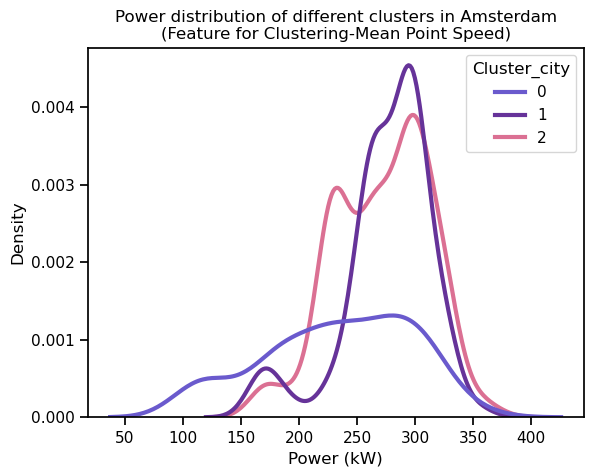

In [84]:
# palette_2 = sns.color_palette(["slateblue","coral","rebeccapurple","palevioletred"])
palette_2 = sns.color_palette(["slateblue","rebeccapurple","palevioletred","coral"])
palette_2
sns.set_palette("CMRmap")
sns.kdeplot(data=df_discussion,x="Power_int",hue="Cluster_city",linewidth=3,palette=palette_2)
plt.xlabel("Power (kW)")
plt.title("Power distribution of different clusters in Amsterdam"+"\n"+"(Feature for Clustering-Mean Point Speed)")
# plt.legend(title='Cluster')
# plt.legend(title="Cluster")

Text(0.5, 0, 'Clusters')

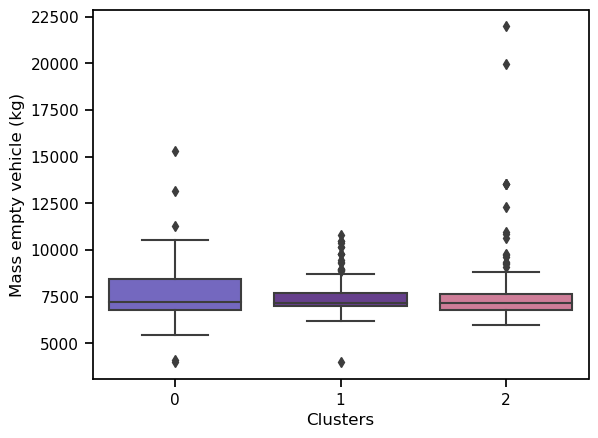

In [85]:
# palette_2 = sns.color_palette(["slateblue","coral","rebeccapurple","palevioletred"])
palette_2 = sns.color_palette(["slateblue","rebeccapurple","palevioletred","coral"])
palette_2
sns.set_palette("CMRmap")
sns.boxplot(data=df_discussion,y="Mass_empty_vehicle_int",x="Cluster_city",palette=palette_2)
plt.ylabel("Mass empty vehicle (kg)")
plt.xlabel("Clusters")
# plt.title("Power distribution of different clusters in Amsterdam"+"\n"+"(Feature for Clustering-Norm HW-L(I))")
# plt.legend(title='Cluster')
# plt.legend(title="Cluster")

Text(0.5, 1.0, 'Engine Power of different clusters in Amsterdam\n(Feature for clustering - Mean Point Speed )')

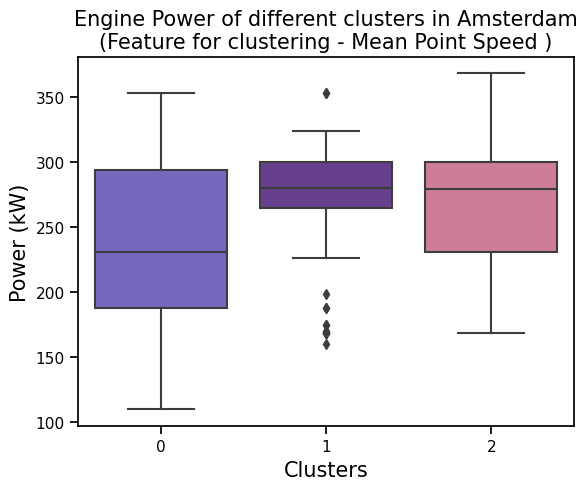

In [86]:
# palette_2 = sns.color_palette(["slateblue","coral","rebeccapurple","palevioletred"])
palette_2 = sns.color_palette(["slateblue","rebeccapurple","palevioletred","coral"])
palette_2
sns.set_palette("CMRmap")
sns.boxplot(data=df_outer_kentekens,y="Power_int",x="Cluster_city",palette=palette_2)
plt.ylabel("Power (kW)",fontsize=15)
plt.xlabel("Clusters",fontsize=15)
plt.title("Engine Power of different clusters in Amsterdam"+"\n"+"(Feature for clustering - "+ feature_name+")",fontsize=15)
# plt.legend(title='Cluster')
# plt.legend(title="Cluster")

Text(0.5, 1.0, 'Engine capacity of different clusters in Amsterdam\n(Feature for clustering - Mean Point Speed )')

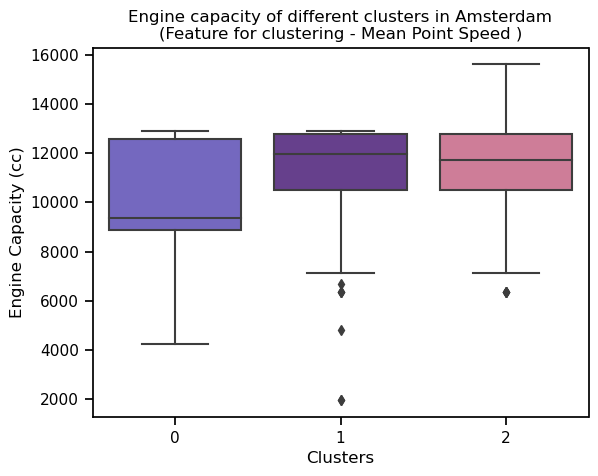

In [87]:
# palette_2 = sns.color_palette(["slateblue","coral","rebeccapurple","palevioletred"])
palette_2 = sns.color_palette(["slateblue","rebeccapurple","palevioletred","coral"])
palette_2
sns.set_palette("CMRmap")
sns.boxplot(data=df_outer_kentekens,y="Cylinder_capacity_int",x="Cluster_city",palette=palette_2)
plt.ylabel("Engine Capacity (cc)")
plt.xlabel("Clusters")
plt.title("Engine capacity of different clusters in Amsterdam"+"\n"+"(Feature for clustering - "+ feature_name+")")
# plt.legend(title='Cluster')
# plt.legend(title="Cluster")

In [88]:
df_discussion.columns

Index(['Numberplate', 'Brand_x', 'Year', 'Mass empty vehicle',
       'Cylinder capacity', 'Power_int', 'Transporter', 'Unnamed: 0_x',
       'Mean Point Speed in Amsterdam', 'Km_travelled_x',
       'Norm Braking Events in Amsterdam', 'Norm L(I)-HW in Amsterdam',
       'Norm L(II)-HW in Amsterdam', 'Norm L(III)-HW in Amsterdam',
       'norm_Lane Departure Warning = OFF_x', 'Norm L-LDW in Amsterdam',
       'Norm R-LDW in Amsterdam', 'City_x', 'Clusters_x', 'Unnamed: 0_y',
       'Mean Point Speed across cities the NL', 'Km_travelled_y',
       ' Indicators = OFF', 'Norm Braking Events across cities the NL',
       'Norm L(I)-HW across cities the NL',
       'Norm L(II)-HW across cities the NL',
       'Norm L(III)-HW across cities the NL',
       'norm_Lane Departure Warning = OFF_y',
       'Norm L-LDW across cities the NL', 'Norm R-LDW across cities the NL',
       'City_y', 'Clusters_y', 'Cluster_city', 'Mass_empty_vehicle_int',
       'cluster_comp'],
      dtype='object')

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\2826233433.py:4: UserWarning:

The palette list has more values (4) than needed (3), which may not be intended.



Text(0.5, 1.0, 'Engine Capacity of different clusters in Amsterdam \n(Feature for Clustering-Mean Point Speed)')

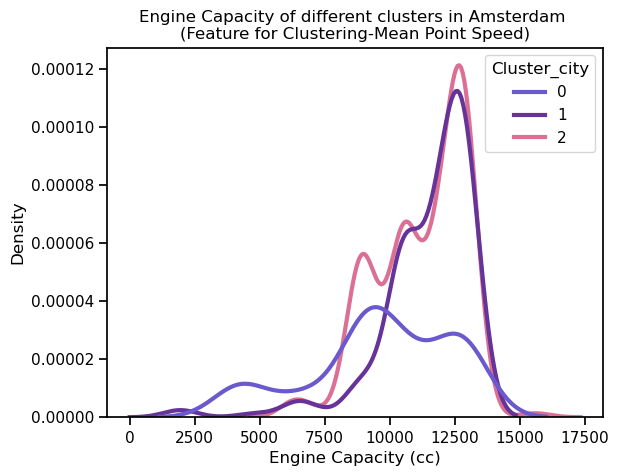

In [89]:
palette_2 = sns.color_palette(["slateblue","rebeccapurple","palevioletred","coral"])
palette_2
sns.set_palette("CMRmap")
sns.kdeplot(data=df_outer_kentekens,x="Cylinder_capacity_int",hue="Cluster_city",linewidth=3,palette=palette_2)
plt.xlabel("Engine Capacity (cc)")
plt.title("Engine Capacity of different clusters in Amsterdam "+"\n"+"(Feature for Clustering-Mean Point Speed)")

C:\Users\ivasu\AppData\Local\Temp\ipykernel_18008\633178927.py:4: UserWarning:

The palette list has more values (4) than needed (3), which may not be intended.



Text(0.5, 1.0, 'Power distribution of different clusters in Amsterdam \n(Feature for Clustering-Mean Point Speed)')

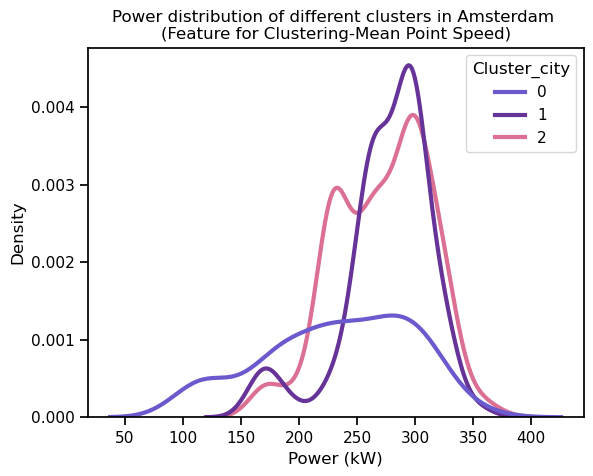

In [90]:
palette_2 = sns.color_palette(["slateblue","rebeccapurple","palevioletred","coral"])
palette_2
sns.set_palette("CMRmap")
sns.kdeplot(data=df_outer_kentekens,x="Power_int",hue="Cluster_city",linewidth=3,palette=palette_2)
plt.xlabel("Power (kW)")
plt.title("Power distribution of different clusters in Amsterdam "+"\n"+"(Feature for Clustering-Mean Point Speed)")

In [91]:
df_discussion.columns

Index(['Numberplate', 'Brand_x', 'Year', 'Mass empty vehicle',
       'Cylinder capacity', 'Power_int', 'Transporter', 'Unnamed: 0_x',
       'Mean Point Speed in Amsterdam', 'Km_travelled_x',
       'Norm Braking Events in Amsterdam', 'Norm L(I)-HW in Amsterdam',
       'Norm L(II)-HW in Amsterdam', 'Norm L(III)-HW in Amsterdam',
       'norm_Lane Departure Warning = OFF_x', 'Norm L-LDW in Amsterdam',
       'Norm R-LDW in Amsterdam', 'City_x', 'Clusters_x', 'Unnamed: 0_y',
       'Mean Point Speed across cities the NL', 'Km_travelled_y',
       ' Indicators = OFF', 'Norm Braking Events across cities the NL',
       'Norm L(I)-HW across cities the NL',
       'Norm L(II)-HW across cities the NL',
       'Norm L(III)-HW across cities the NL',
       'norm_Lane Departure Warning = OFF_y',
       'Norm L-LDW across cities the NL', 'Norm R-LDW across cities the NL',
       'City_y', 'Clusters_y', 'Cluster_city', 'Mass_empty_vehicle_int',
       'cluster_comp'],
      dtype='object')

Text(0.5, 1.0, 'Power (kW) ')

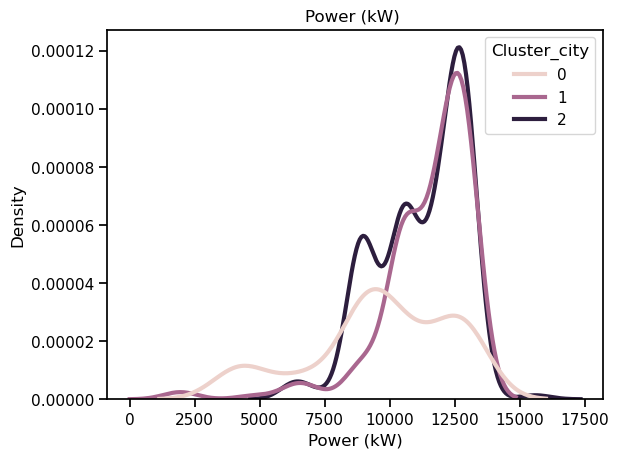

In [92]:
sns.kdeplot(data=df_outer_kentekens,x="Cylinder_capacity_int",hue="Cluster_city",linewidth=3)
plt.xlabel("Power (kW)")
plt.title("Power (kW) ")

In [93]:
city_norml1_hw=pd.read_excel(r"C:\Users\ivasu\Desktop\Robotics\2021-2022\Thesis\code\DataAnalysis\CarrierWeb\Data\Book12.xlsx")
city_norml1_hw

,City,Cluster,Feature,Mass (kg),Power (kW),Unnamed: 5
0,Amsterdam,0,Mean Point Speed,7287.5,188.0,NaN
1,Amsterdam,1,Mean Point Speed,7150.0,279.0,NaN
2,Amsterdam,2,Mean Point Speed,7220.0,265.0,NaN
3,Amsterdam,3,Mean Point Speed,7150.0,283.5,NaN
4,Rotterdam,0,Mean Point Speed,7372.5,300.0,NaN
5,Rotterdam,1,Mean Point Speed,7150.0,265.0,265.0
6,Rotterdam,2,Mean Point Speed,7220.0,294.0,NaN
7,Rotterdam,3,Mean Point Speed,7150.0,265.0,NaN
8,Zwolle,0,Mean Point Speed,7745.0,243.0,NaN
9,Zwolle,1,Mean Point Speed,7150.0,265.0,NaN


<AxesSubplot:xlabel='Cluster ', ylabel='Power (kW)'>

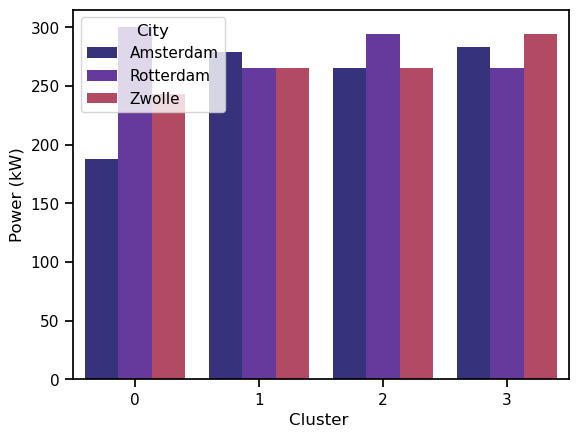

In [94]:
sns.barplot(y=city_norml1_hw["Power (kW)"],x=city_norml1_hw["Cluster "],hue=city_norml1_hw["City"])